In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib import cm
import numpy as np
import random
import json
from IPython.display import clear_output

from result_plots.ProfilingBased.common.common import read_data, get_metric_mapping
from result_plots.ProfilingBased.common.process_data_from_solver import get_mean_from_iterations, normalize_error_result, get_ensemble_error
from result_plots.ProfilingBased.common.plot import get_result_from_pkl, get_x_position, get_xtick_position, \
                                                plot_raw, get_gain, gain_over_strawman, consolidate_gain_over_strawman

In [2]:
def plot_heatmap(error_reductions, ytick_labels, xtick_labels, title="Error reduction"):
#     ytick_labels = ["caida", "uniform", "zipf"]
#     xtick_labels = ["caida", "uniform", "zipf"]

#     error_reductions = np.array([[55, 59, 62, ],
#                         [-10, 95, 80, ],
#                         [35, 95, 99, ]])

    ### https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html
    # create color maps
    top = cm.get_cmap('Oranges_r', 128)
    bottom = cm.get_cmap('Blues', 128)
    colors = np.vstack((top(np.linspace(0, 1, 128)),
                           bottom(np.linspace(0, 1, 128))))
    cmp = mcolors.ListedColormap(colors, name='OrangeBlue')

    ### Creating annotated heatmaps
    ### https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html

    fig, ax = plt.subplots()
    im = ax.imshow(error_reductions, cmap=cmp, vmin=-100, vmax=100)

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(xtick_labels)), labels=xtick_labels, size=18)
    ax.set_yticks(np.arange(len(ytick_labels)), labels=ytick_labels, size=18)

    # # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    #          rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(ytick_labels)):
        for j in range(len(xtick_labels)):
            text = ax.text(j, i, f"{error_reductions[i, j]:.2f}",
                           ha="center", va="center", color="w", size=18)

    ax.set_title(f"{title}", size=18)
    ax.set_ylabel("training sets", size=18)
    ax.set_xlabel("testing sets", size=18)

    fig.colorbar(im)

    fig.tight_layout()
    plt.show()

In [3]:
def call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name = "Test", \
                  mem_size = 131072, all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd'], isSaveFig = False):
    plot_raw(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, all_metrics, isSaveFig)
    gain_result = gain_over_strawman(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, all_metrics, isSaveFig)
    merge_gain_result = consolidate_gain_over_strawman(gain_result, name, all_metrics, isSaveFig)
    
    global global_merge_gain_all_mem
    for d in merge_gain_result:
        global_merge_gain_all_mem.append(d)

    global global_name_all_mem
    global_name_all_mem.append(name)
    

## Common variables

In [5]:
seeds = [1, 2, 3, 4, 5]
count = 1

# flowkeys = ["dstIP,dstPort",]
flowkeys = ["srcIP",]
epochs = ['30']

isSaveFig = False

all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd']
mem_size = 131072

In [6]:
## Global variables
## !!, must reset every time
global_merge_gain_all_mem = []
global_name_all_mem = []

## record ensemble error per box
global_ensemble_error = []

In [7]:
# # caida
datasets_caida = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]

# # uniform-100
datasets_uniform_100 = ['20180517-130900-uniform-100-srcIP.pcap/', '20180517-131000-uniform-100-srcIP.pcap/','20180517-131100-uniform-100-srcIP.pcap/',
            '20180621-130900-uniform-100-srcIP.pcap/', '20180621-131000-uniform-100-srcIP.pcap/','20180621-131100-uniform-100-srcIP.pcap/', 
            '20180816-130900-uniform-100-srcIP.pcap/', '20180816-131000-uniform-100-srcIP.pcap/','20180816-131100-uniform-100-srcIP.pcap/', ]

# # zipf-1.1-srcIP
datasets_zipf_1point1 = ['20180517-130900-zipf-1.1-srcIP.pcap/', '20180517-131000-zipf-1.1-srcIP.pcap/','20180517-131100-zipf-1.1-srcIP.pcap/',
            '20180621-130900-zipf-1.1-srcIP.pcap/', '20180621-131000-zipf-1.1-srcIP.pcap/','20180621-131100-zipf-1.1-srcIP.pcap/', 
            '20180816-130900-zipf-1.1-srcIP.pcap/', '20180816-131000-zipf-1.1-srcIP.pcap/','20180816-131100-zipf-1.1-srcIP.pcap/', ]

---

## Plot selection results

In [8]:
def loop_unit_caida(datasets):
    global global_ensemble_error
    name = 'caida'

    ret_sol1_ll = []
    ret_sol2_ll = []
    ret_sol3_ll = []
    ret_sol4_ll = []
    ret_us_ll = []
    
    
    # ========== mem_131072.json ==========

    #############################
    ret_us = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [3]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [2048]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    ret_us_ll.append(ret_us)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [65536]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol3 = {} 

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['entropy', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['fsd', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['change_det', 'hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['fsd', 'entropy', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['fsd', 'entropy', 'change_det', 'hh', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [524288]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol4 = {} 

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['entropy', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['fsd', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['change_det', 'hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['fsd', 'entropy', 'change_det', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['fsd', 'entropy', 'change_det', 'hh', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    
    ## pre-processing data
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
    ## Get & record ensemble error
    global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
    ## call plotting
    call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

In [9]:
def loop_unit_uniform(datasets):
    global global_ensemble_error
    name = 'uniform'

    ret_sol1_ll = []
    ret_sol2_ll = []
    ret_sol3_ll = []
    ret_sol4_ll = []
    ret_us_ll = []
    
    
    # ========== mem_131072.json ==========

    #############################
    ret_us = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [1024]
    rows = [3]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    ret_us_ll.append(ret_us)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [65536]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'entropy', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['ll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'entropy', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'entropy', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['ll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'entropy', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    
    ## pre-processing data
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
    ## Get & record ensemble error
    global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
    ## call plotting
    call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

In [10]:
def loop_unit_zipf(datasets):
    global global_ensemble_error
    name = 'zipf1.1'

    ret_sol1_ll = []
    ret_sol2_ll = []
    ret_sol3_ll = []
    ret_sol4_ll = []
    ret_us_ll = []
    
    
    # ========== mem_131072.json ==========

    #############################
    ret_us = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [3]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    ret_us_ll.append(ret_us)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [65536]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', 'hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['ll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', 'hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', 'hh', 'change_det', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['ll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', 'hh', 'change_det', ]
    algos = ['cm']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    
    ## pre-processing data
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
    ## Get & record ensemble error
    global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
    ## call plotting
    call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

Num of run: 5
max_list: {'hh': 13.836771143310065, 'change_det': 12.419081864115473, 'entropy': 37.415700955396275, 'card': 2.882641164317032, 'fsd': 1.55028414288858}


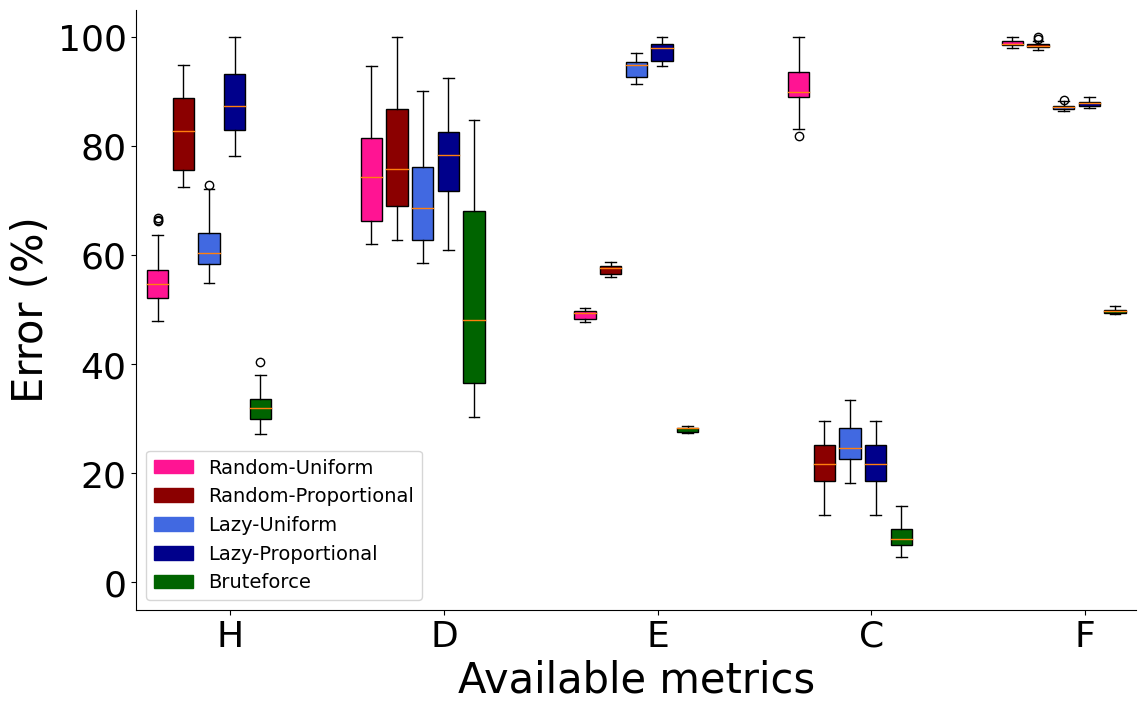

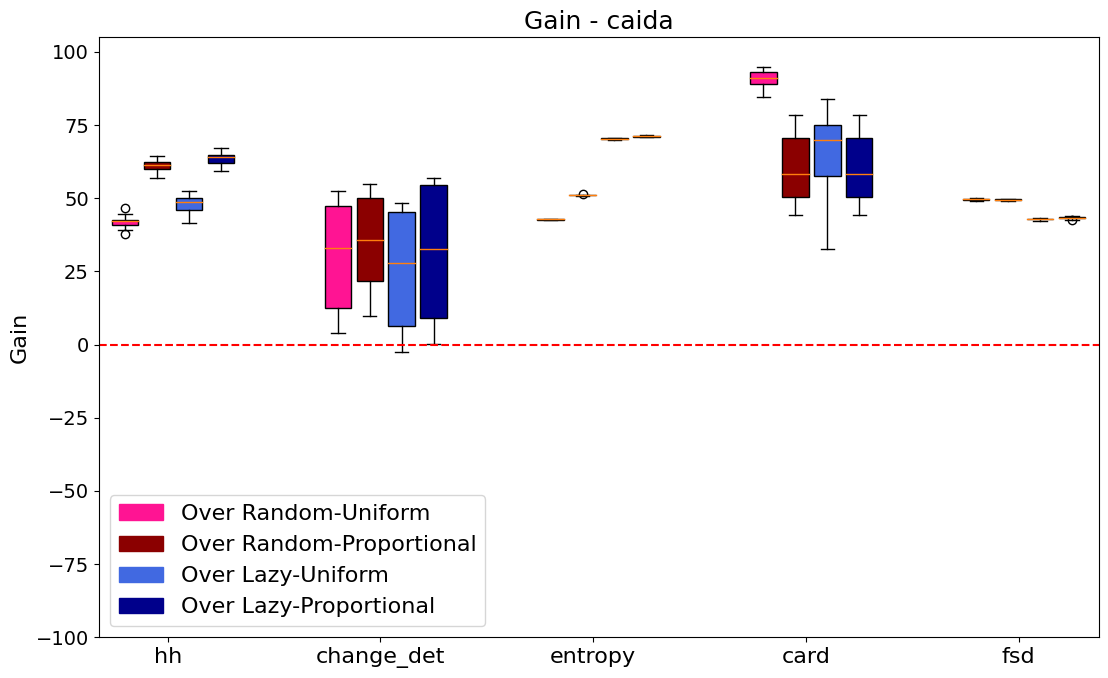

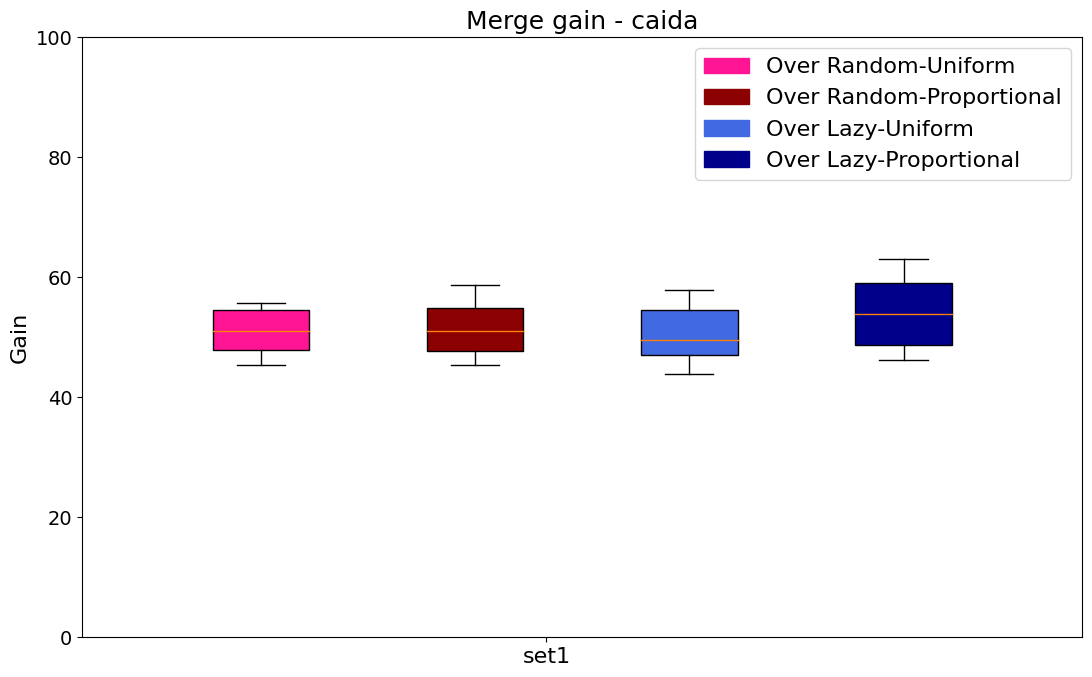

Num of run: 5
max_list: {'hh': 6.836128902406145, 'change_det': 18.839068371495546, 'entropy': 1.526907712970523, 'card': 44764.8307865502, 'fsd': 1.042025827223718}


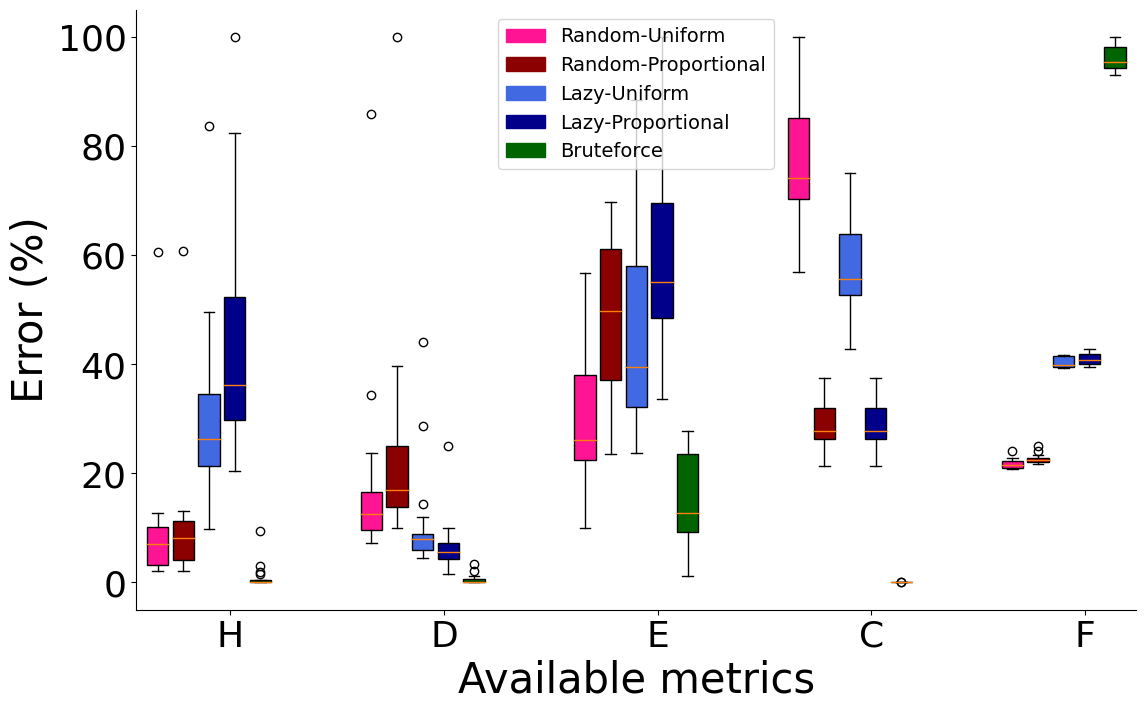

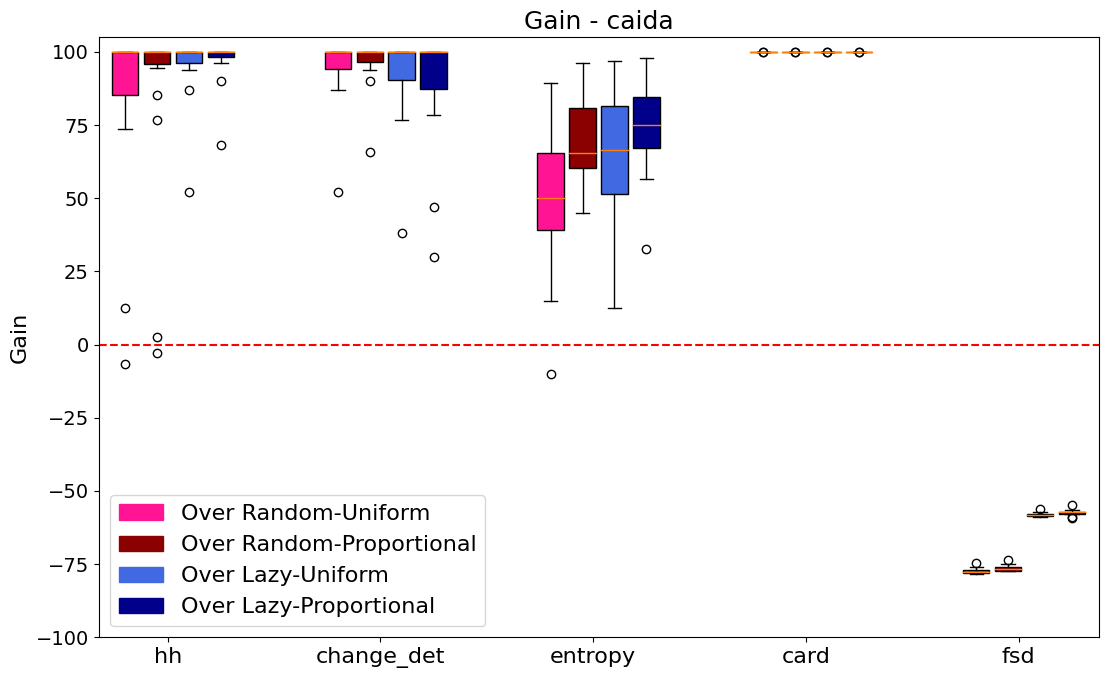

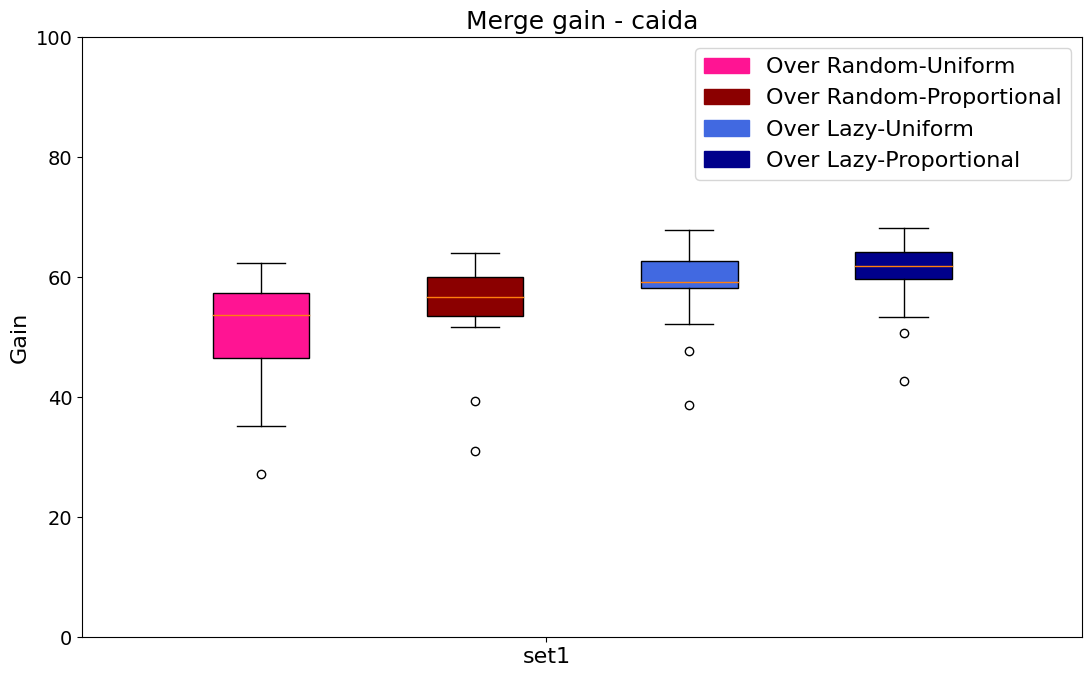

Num of run: 5
max_list: {'hh': 5.181170705899059, 'change_det': 7.129238754702842, 'entropy': 1.7507440306720465, 'card': 3374.0589127795974, 'fsd': 0.7691509867356398}


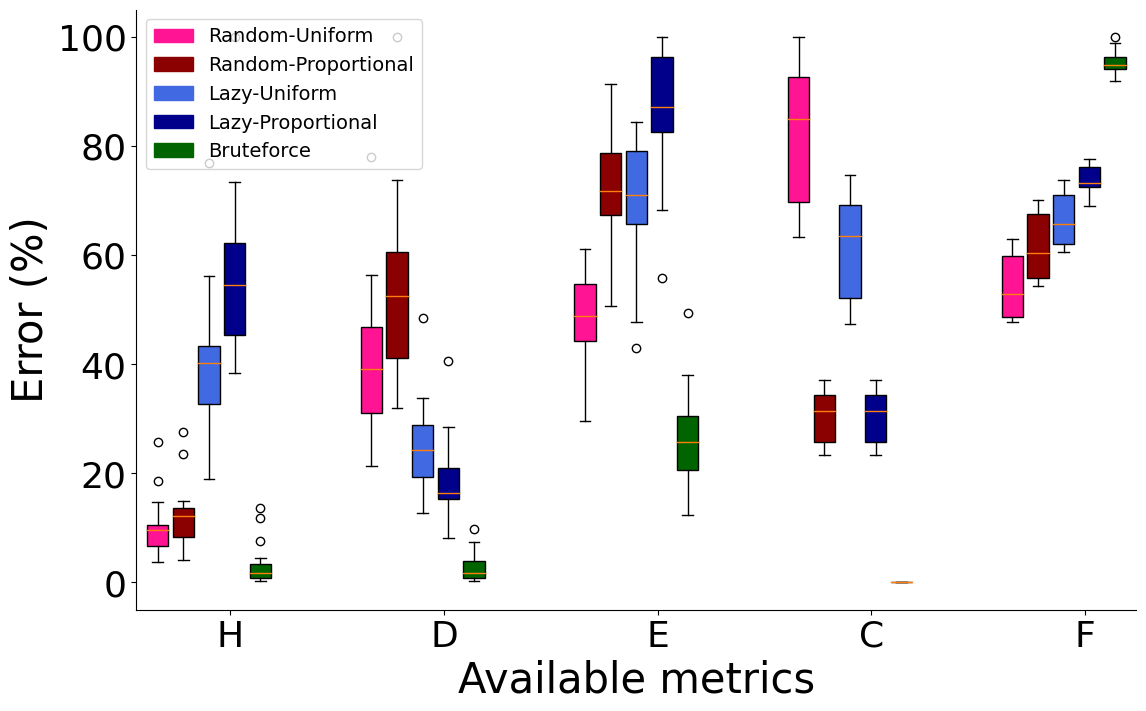

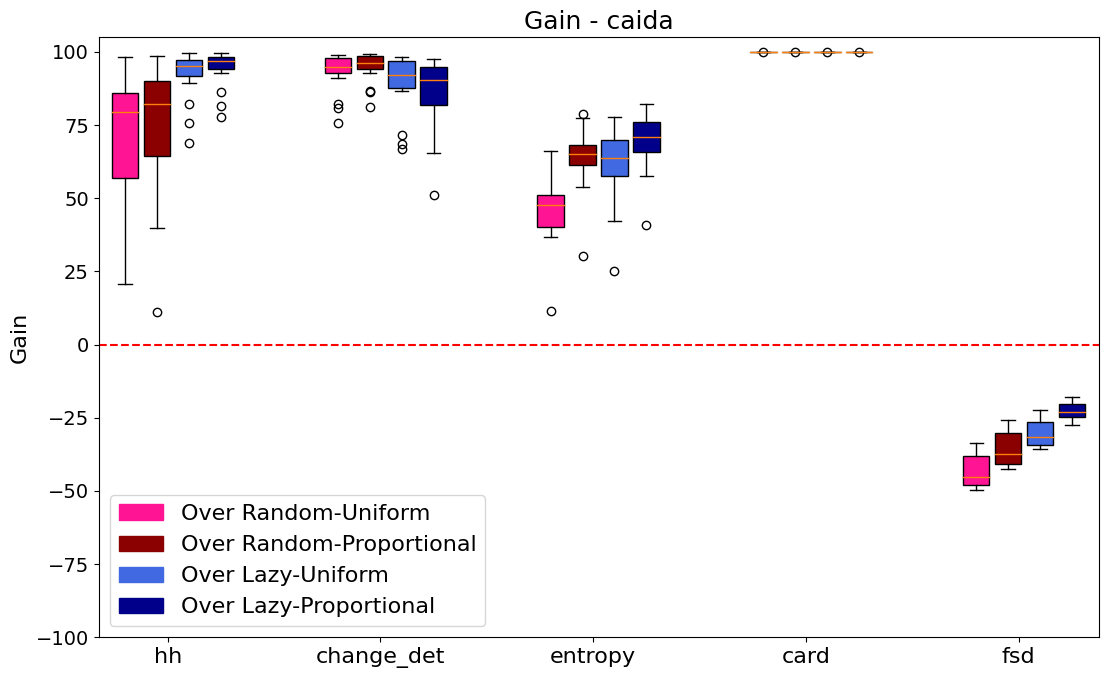

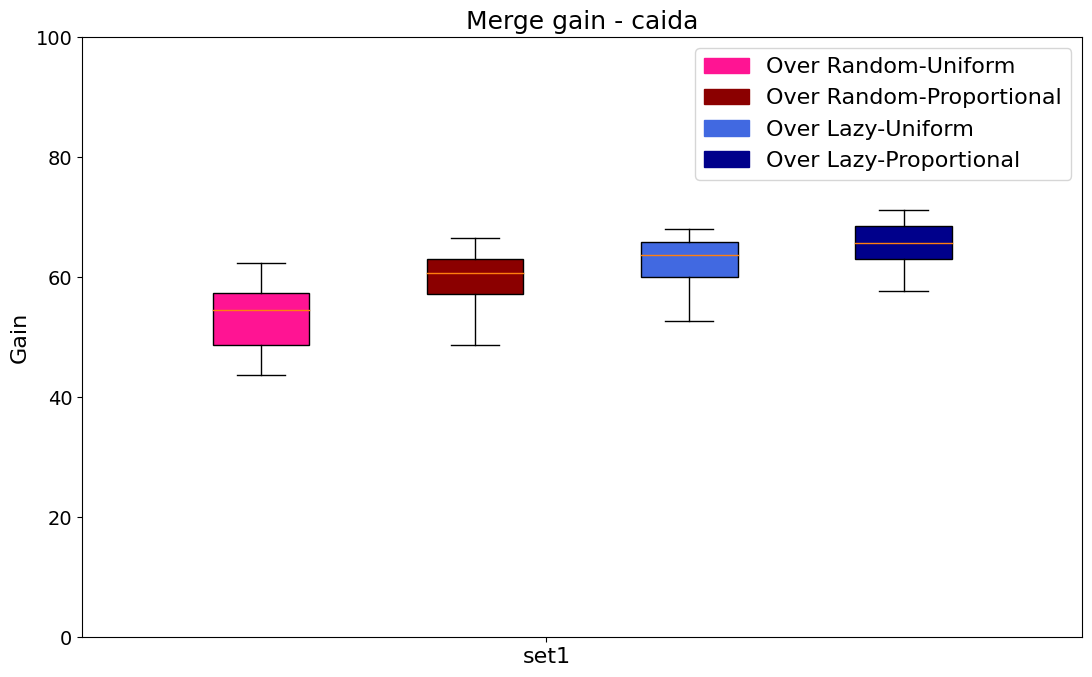

Num of run: 5
max_list: {'hh': 42.152767554858634, 'change_det': 41.567613470625645, 'entropy': 35.8739611419043, 'card': 11.01456420268657, 'fsd': 1.9549677083396038}


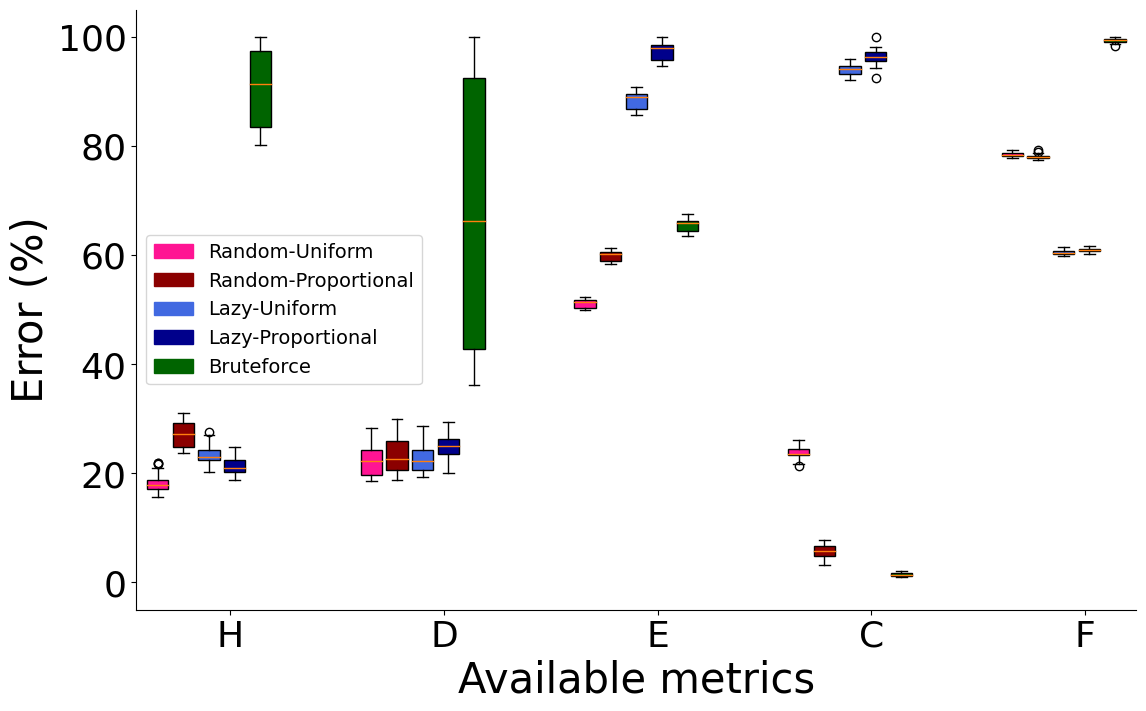

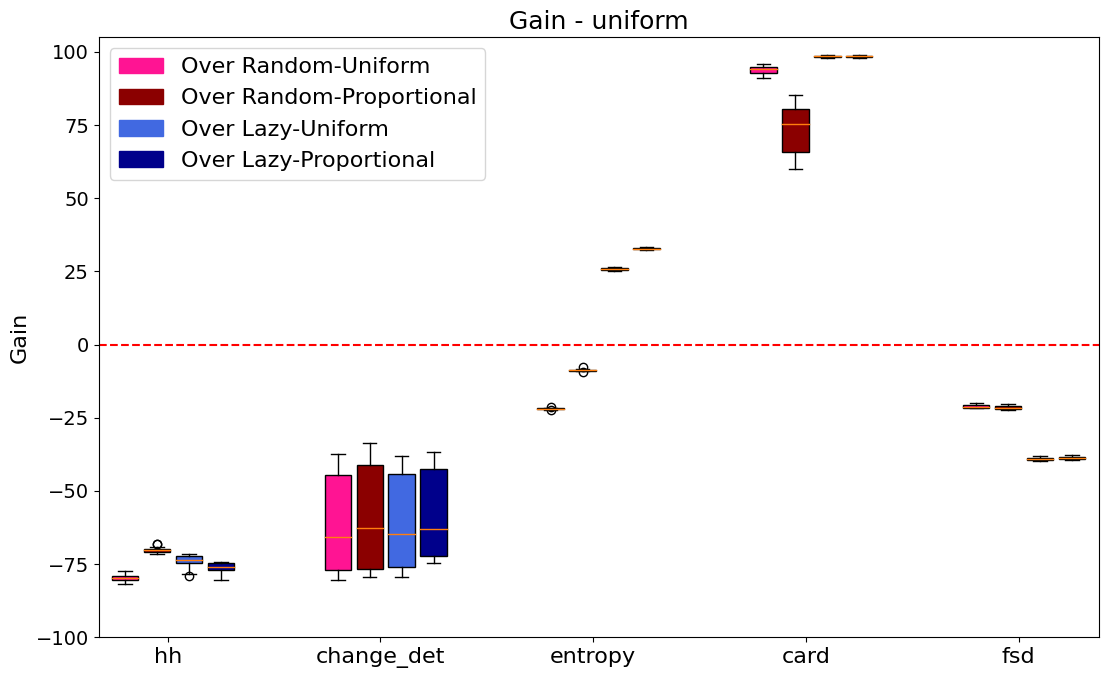

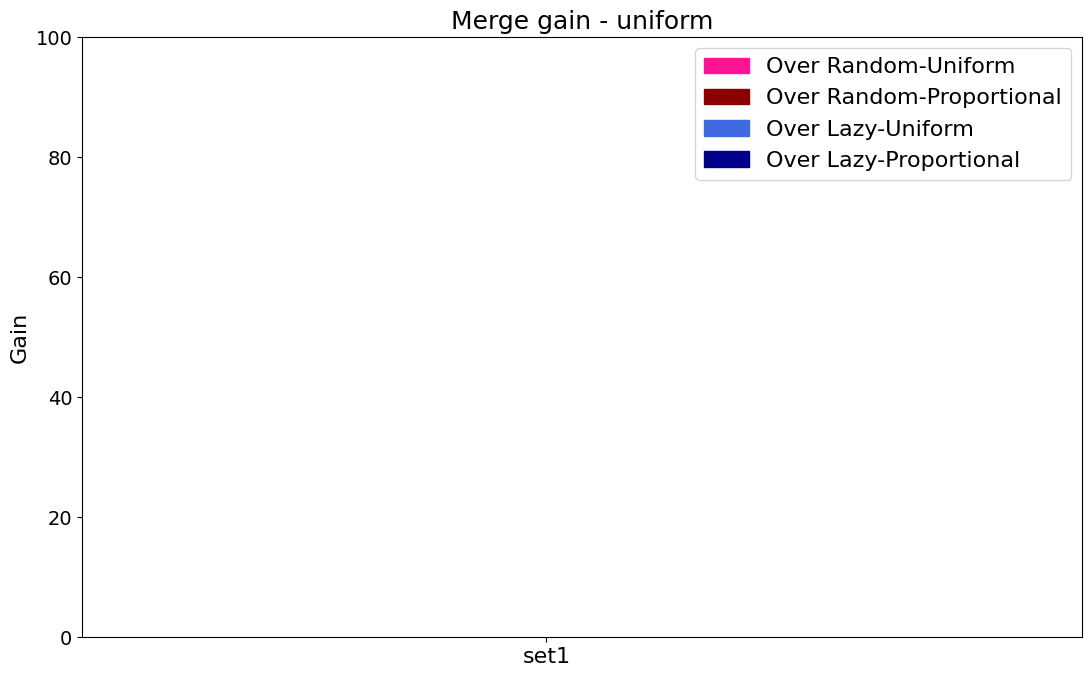

Num of run: 5
max_list: {'hh': 7.0777159342420095, 'change_det': 18.839068371495546, 'entropy': 1.5661005388629974, 'card': 44764.8307865502, 'fsd': 0.6461911414198926}


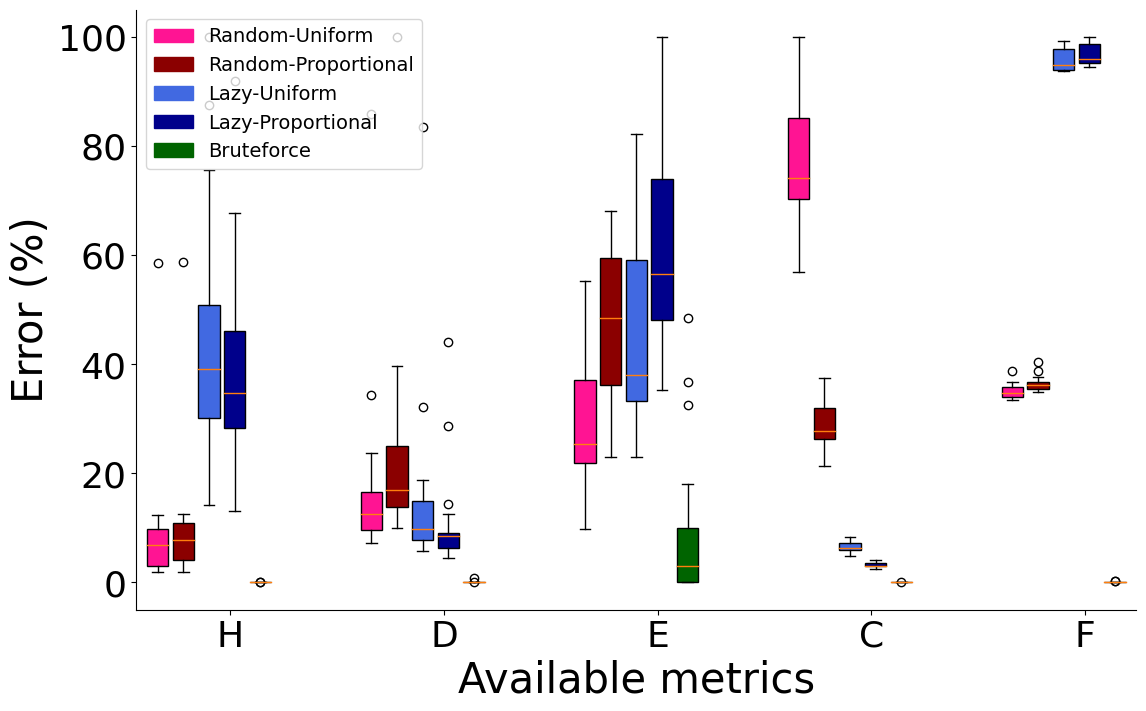

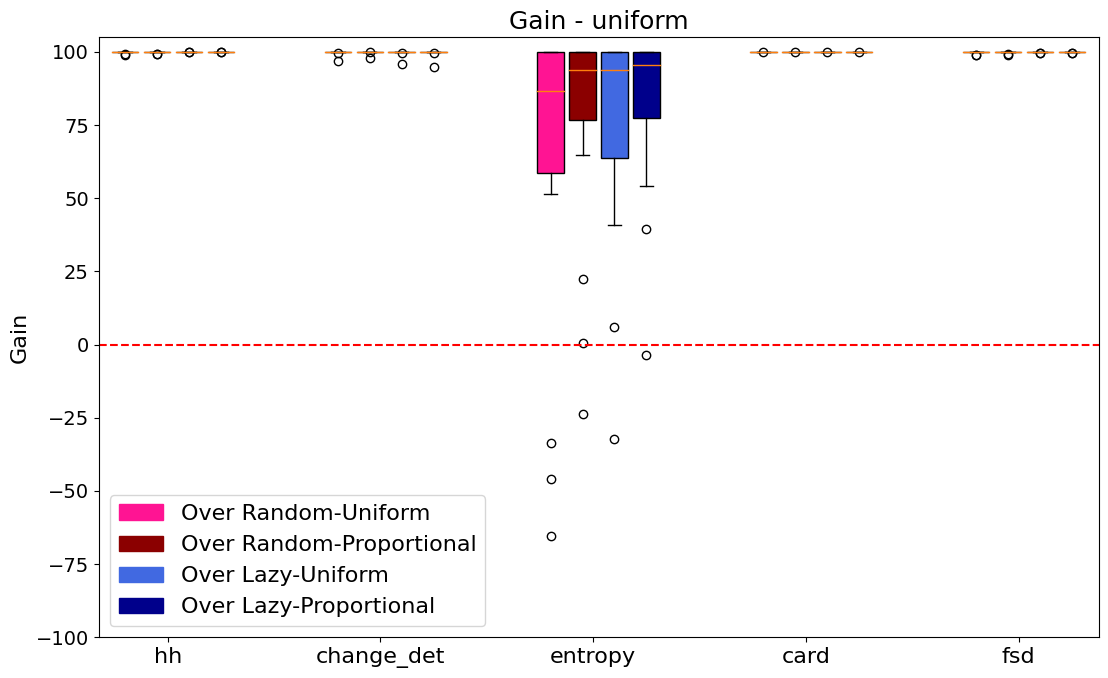

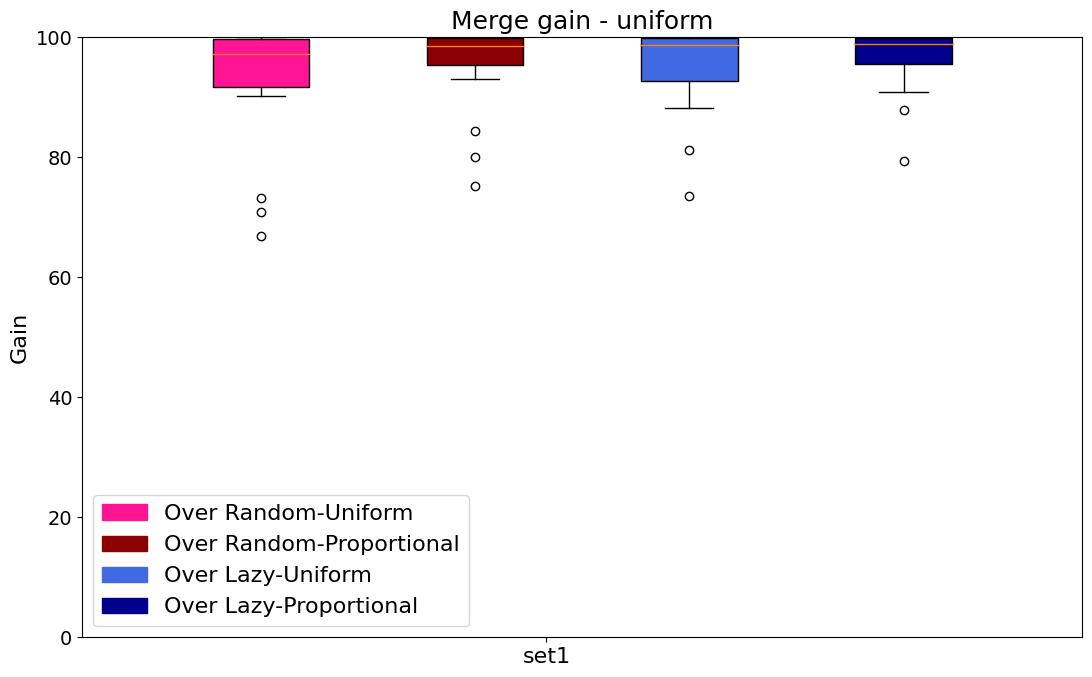

Num of run: 5
max_list: {'hh': 6.047113093159105, 'change_det': 7.129238754702842, 'entropy': 2.0312691433686476, 'card': 3374.0589127795974, 'fsd': 0.7245459296676255}


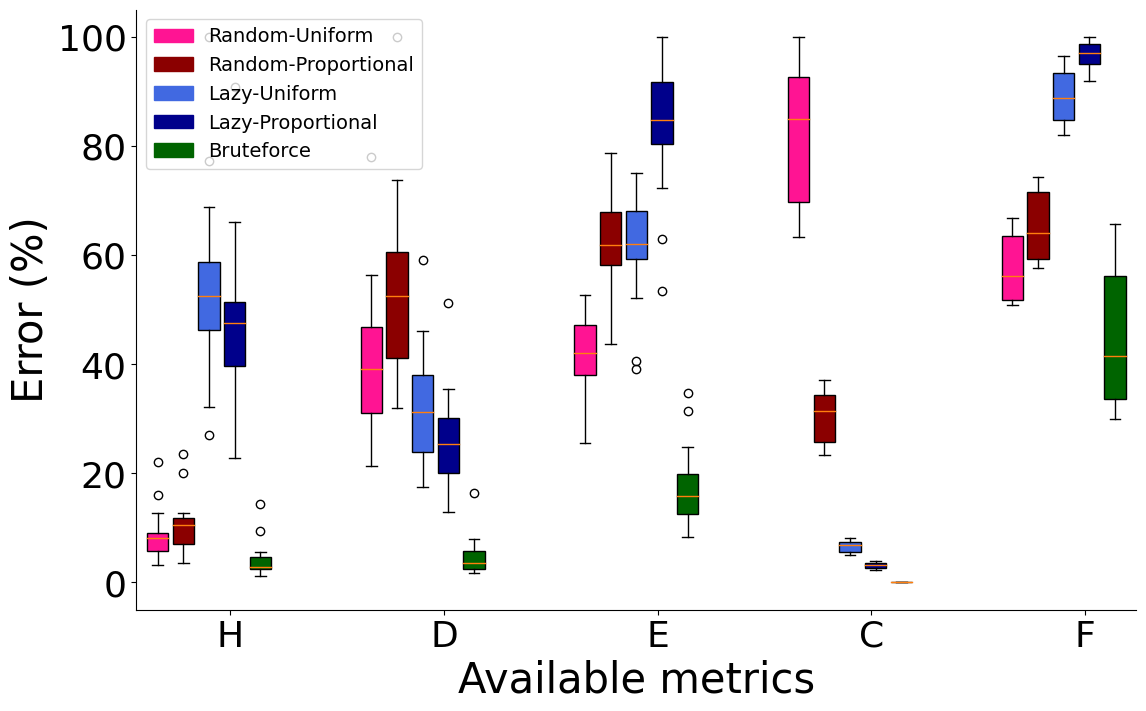

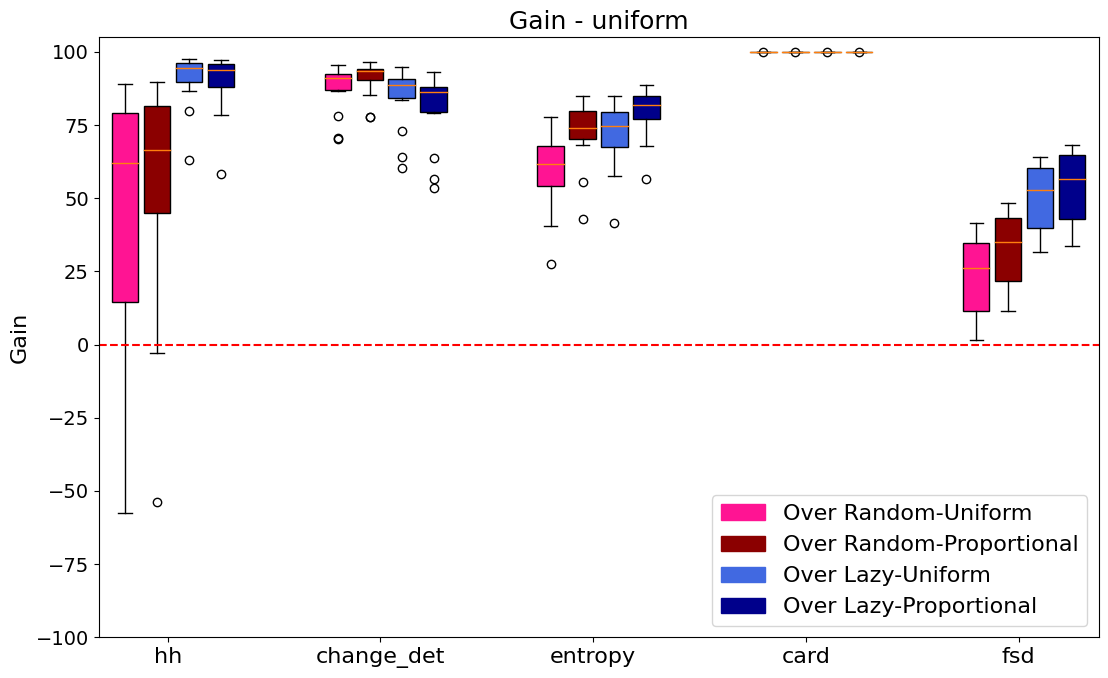

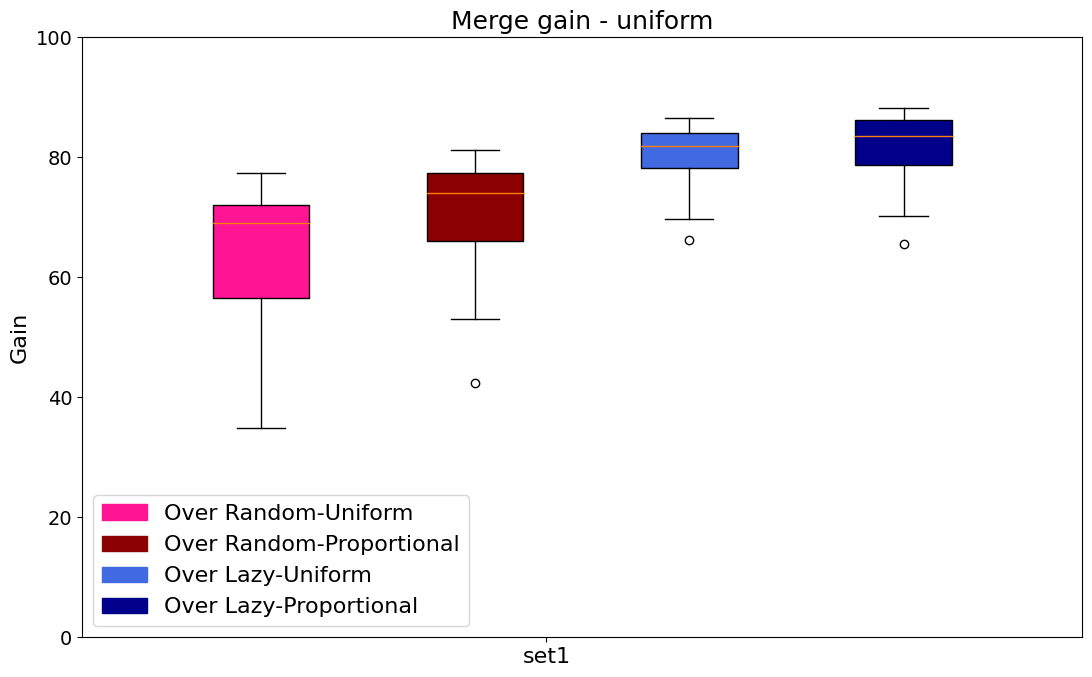

Num of run: 5
max_list: {'hh': 13.124794724397777, 'change_det': 13.124794724397779, 'entropy': 39.55536376555555, 'card': 10.751623791718401, 'fsd': 1.7334779458421026}


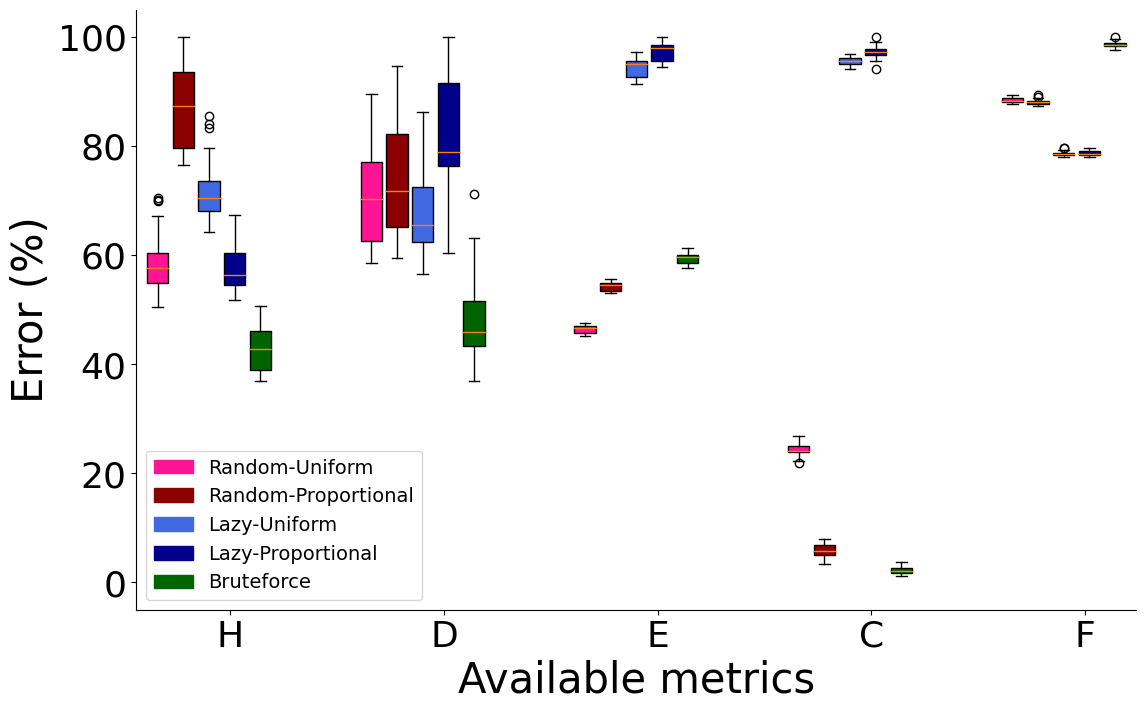

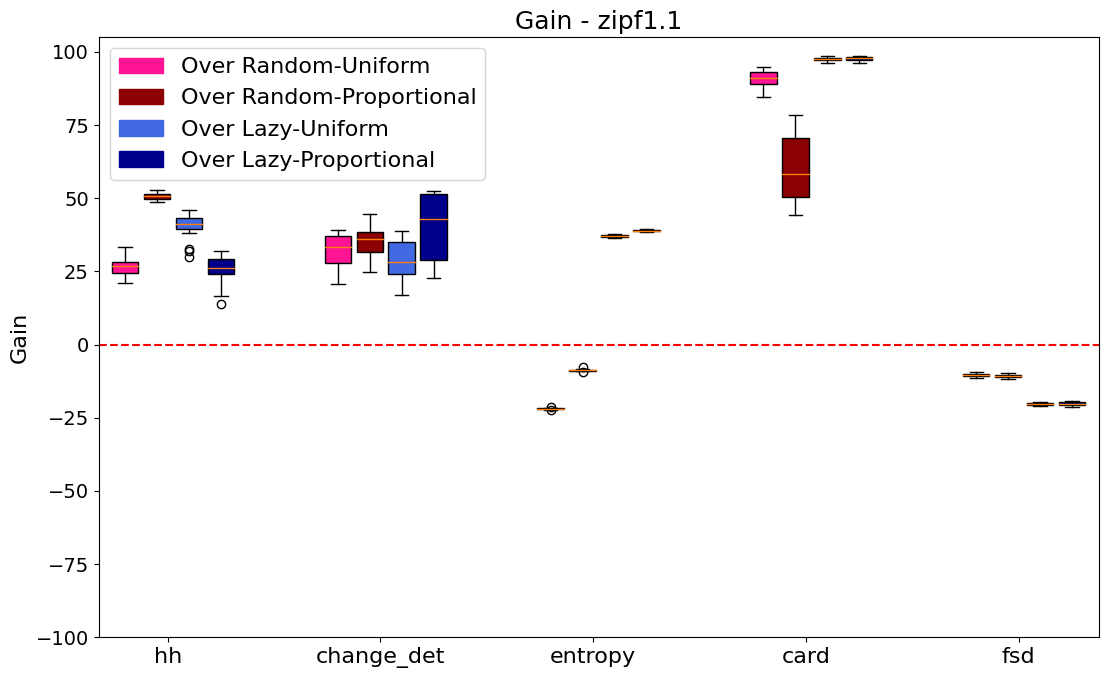

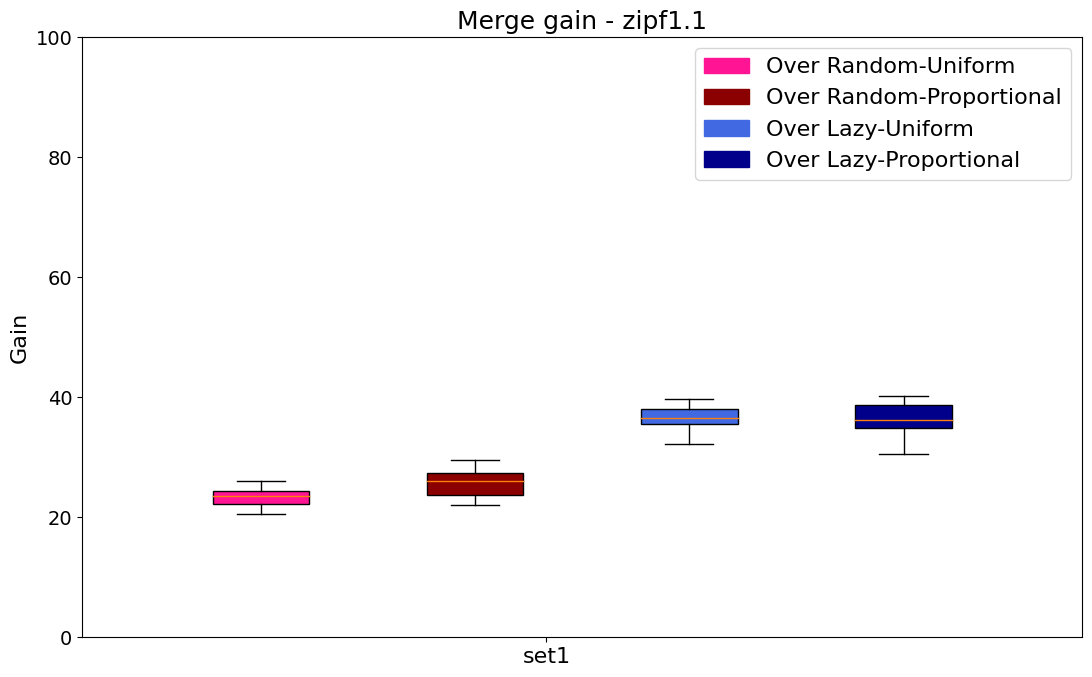

Num of run: 5
max_list: {'hh': 6.289193859990576, 'change_det': 18.839068371495546, 'entropy': 1.6295928558242223, 'card': 44764.8307865502, 'fsd': 0.462014612416244}


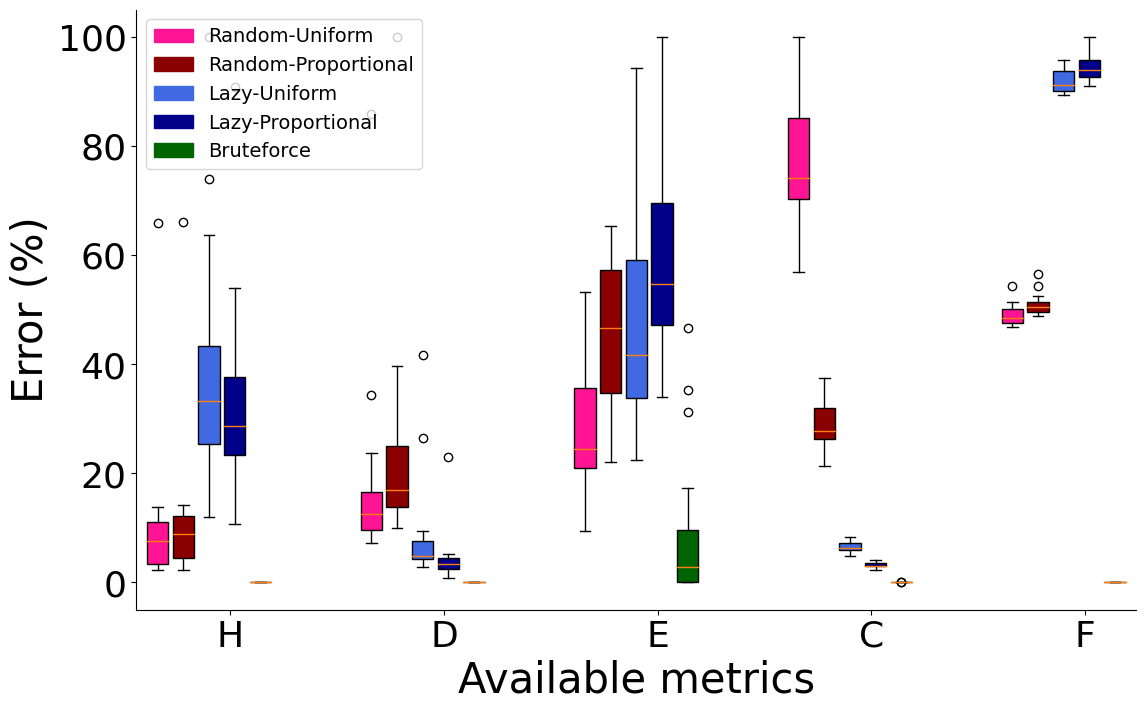

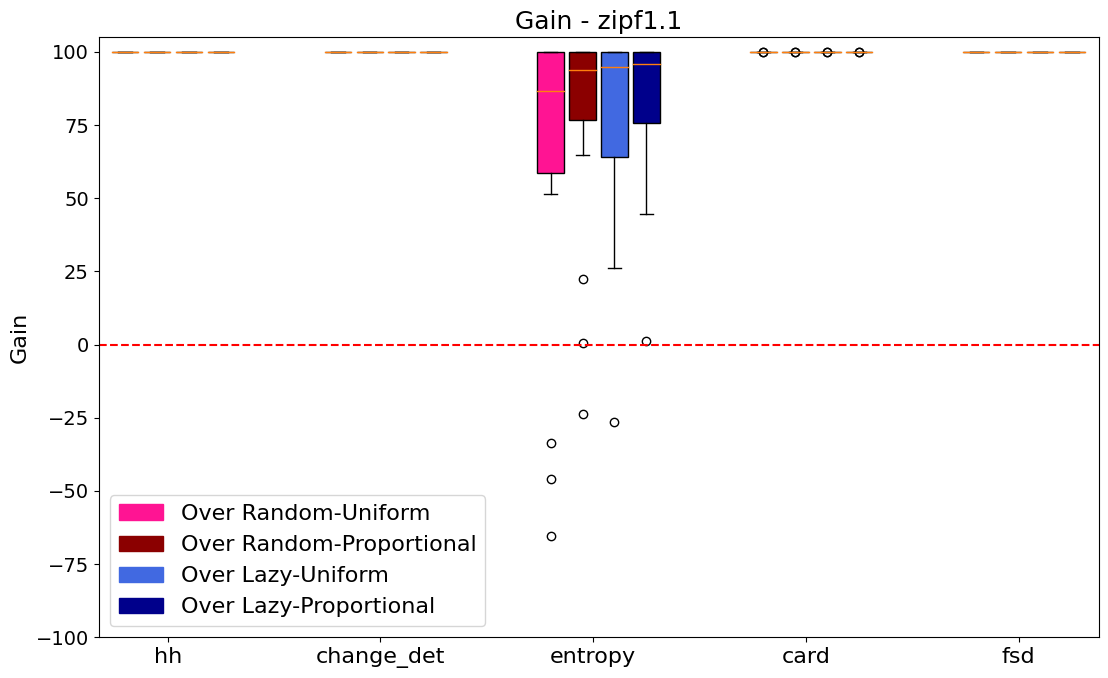

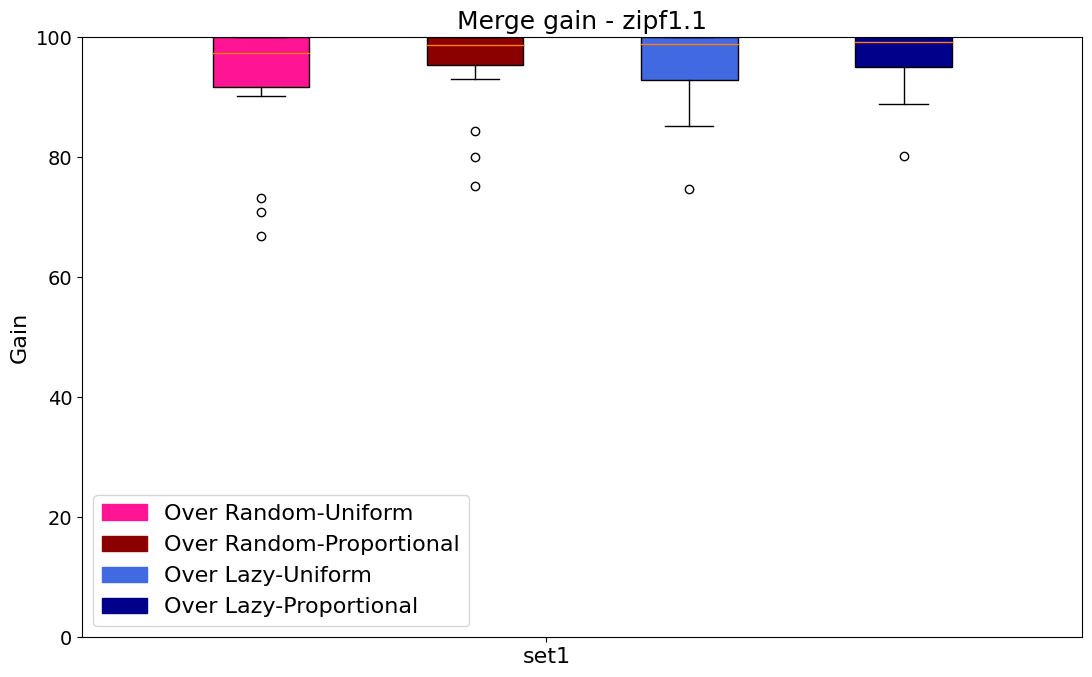

Num of run: 5
max_list: {'hh': 4.539115824570876, 'change_det': 7.129238754702842, 'entropy': 1.9669756219724945, 'card': 3374.0589127795974, 'fsd': 0.6759420672943295}


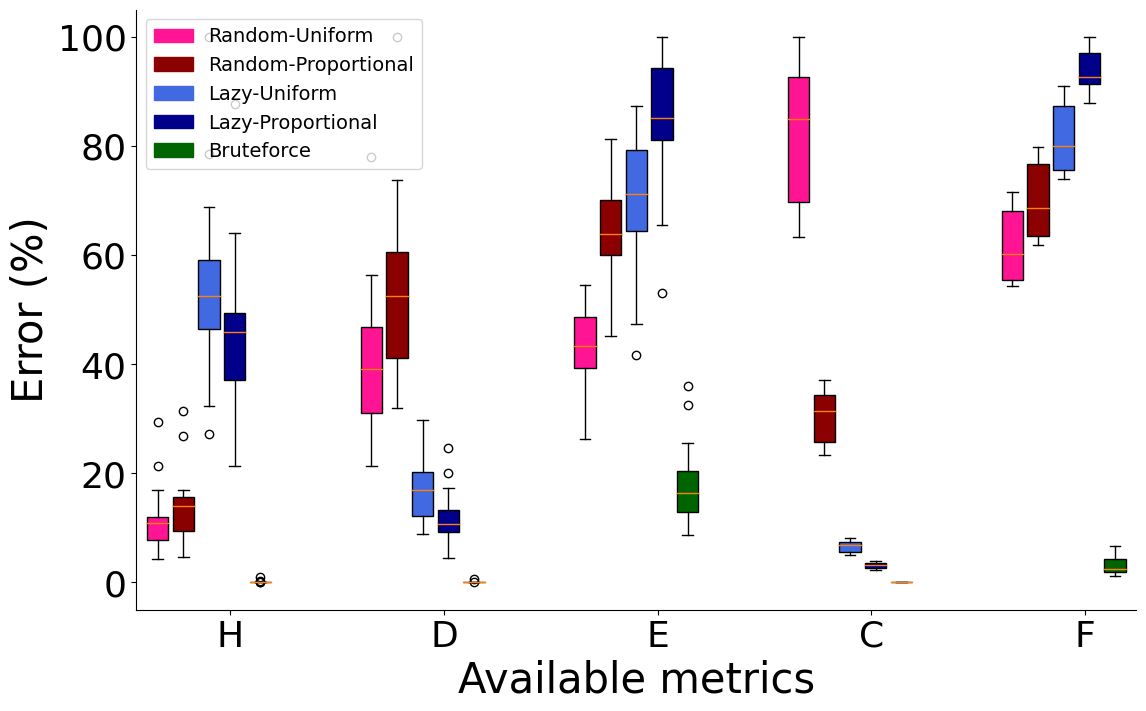

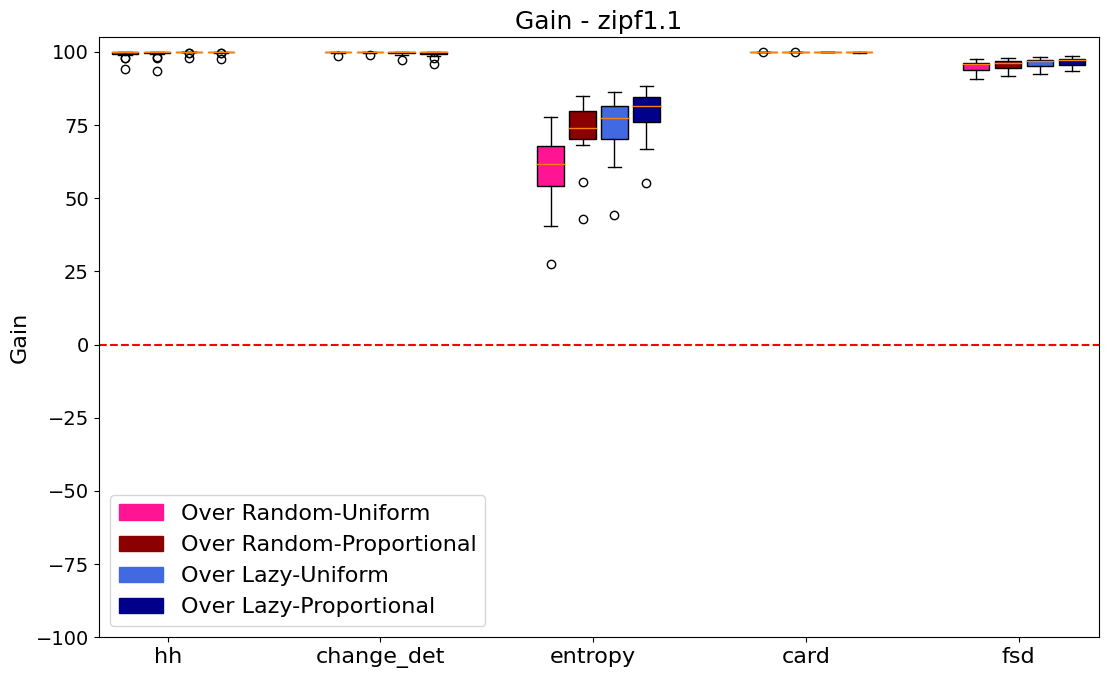

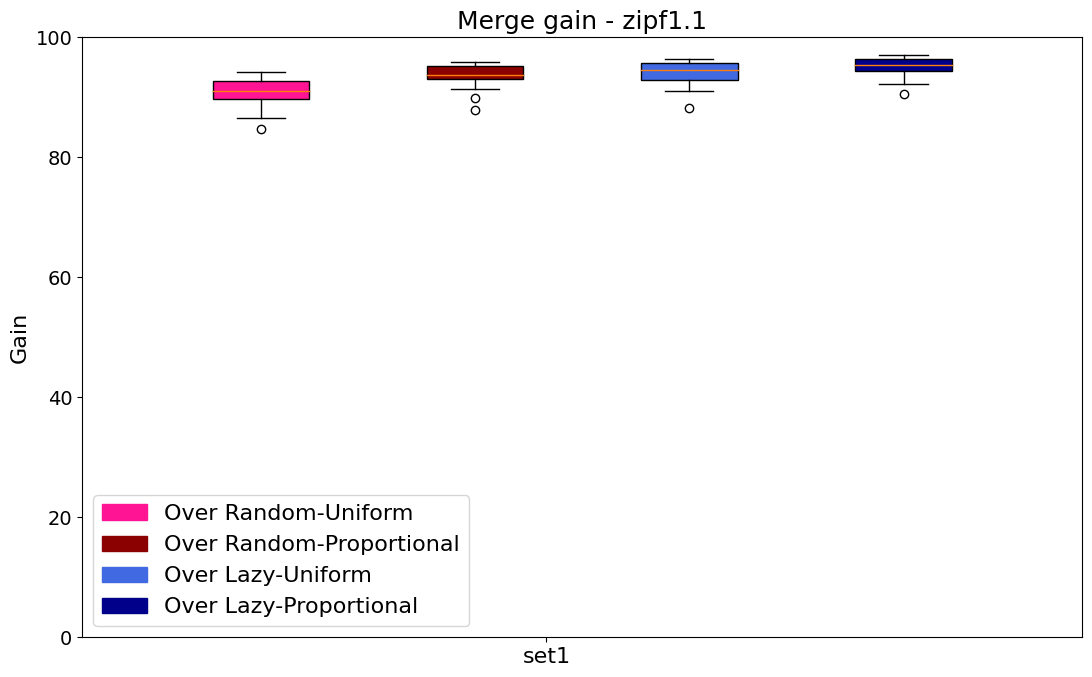

In [11]:
## testing datasets
datasets_list = [datasets_caida, datasets_uniform_100, datasets_zipf_1point1]

## run testing datasets
for datasets in datasets_list:
    ## run testing datasets on a trainingset
    loop_unit_caida(datasets)

for datasets in datasets_list:
    ## run testing datasets on a trainingset
    loop_unit_uniform(datasets)

for datasets in datasets_list:
    ## run testing datasets on a trainingset
    loop_unit_zipf(datasets)
    
# clear_output(wait=True)

In [12]:
# len(global_merge_gain_all_mem)
# global_name_all_mem 

In [17]:
len(global_merge_gain_all_mem)
num_of_strawmen = 4
num_of_datasets = len(datasets_list)

strawman_labels = ['over Random-Uniform', 'over Random-Proportional', 
                    'over Lazy-Uniform', 'over Lazy-Proportional']

In [18]:
ytick_labels = ["caida", "uniform", "zipf"]
xtick_labels = ["caida", "uniform", "zipf"]

title = "Error reduction"

[[ 51.15603458  50.38777458  53.3981958 ]
 [-17.97283853  92.86205454  63.47213667]
 [ 23.46132261  92.93838265  90.8501433 ]]


/tmp/ipykernel_18483/2478466323.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('Oranges_r', 128)
/tmp/ipykernel_18483/2478466323.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('Blues', 128)


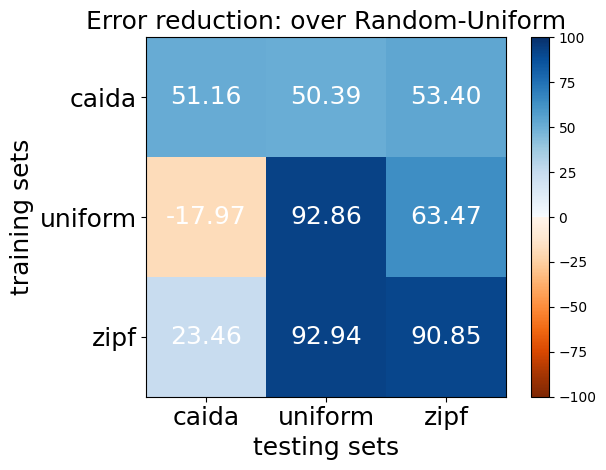

[[ 51.34285438  55.13067192  59.48917869]
 [-16.99568013  95.32836695  70.26831291]
 [ 25.55005434  95.38825923  93.55836529]]


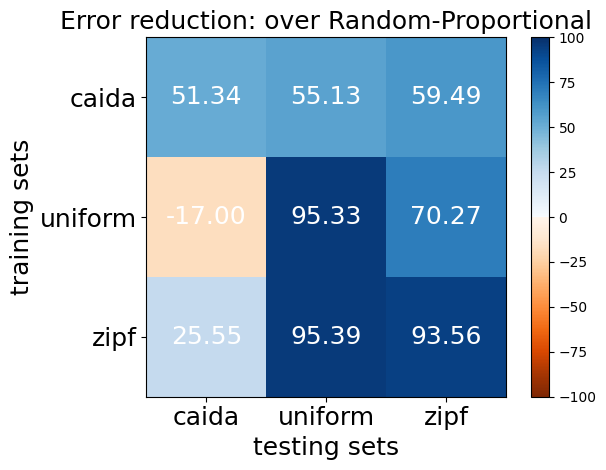

[[50.49513797 58.84181225 62.54767231]
 [-9.85907782 95.20781547 79.84833711]
 [36.74968272 95.75308    94.06642887]]


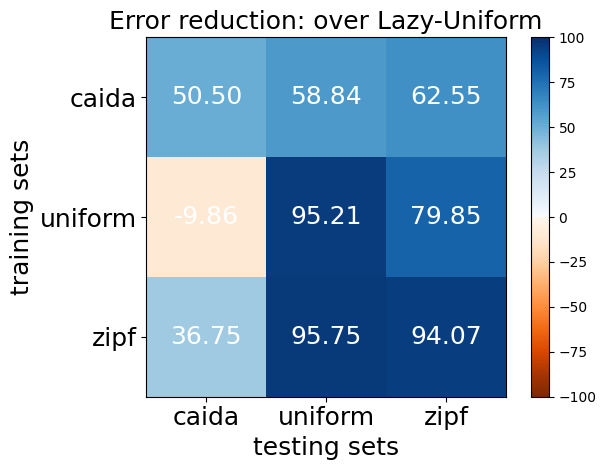

[[53.94223176 60.43409215 65.33475779]
 [-8.32232333 96.5543754  81.12357543]
 [36.43514645 96.73442426 95.04275704]]


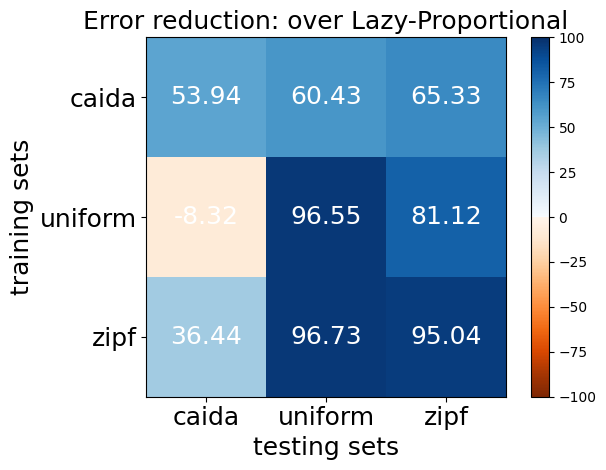

In [19]:
for offset_strawman in range(num_of_strawmen):
    error_reductions = []
    ll = []
    ## iterate over 3x3
    for i in range(num_of_datasets**2):
        idx = i * num_of_strawmen + offset_strawman
        
        # print(idx)
        ll.append(np.mean(global_merge_gain_all_mem[idx]))
        if len(ll) == num_of_datasets:
            error_reductions.append(ll)
            ll = []
    error_reductions = np.array(error_reductions)
    
    title = f"Error reduction: {strawman_labels[offset_strawman]}"
    print(error_reductions)
    
    plot_heatmap(error_reductions, ytick_labels, xtick_labels, title)

---

## FixFlowPkt dataset

In [4]:
seeds = [1, 2, 3, 4, 5]
count = 1

# flowkeys = ["dstIP,dstPort",]
flowkeys = ["srcIP",]
epochs = ['30']

isSaveFig = False

all_metrics = ['hh', 'change_det', 'entropy', 'card', 'fsd']
mem_size = 131072

In [5]:
## Global variables
## !!, must reset every time
global_merge_gain_all_mem = []
global_name_all_mem = []

## record ensemble error per box
global_ensemble_error = []

In [6]:
# # caida
datasets_caida = ['equinix-nyc.dirA.20180517-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180517-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180621-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180621-131100.UTC.anon.pcap/', 
           'equinix-nyc.dirA.20180816-130900.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131000.UTC.anon.pcap/', 'equinix-nyc.dirA.20180816-131100.UTC.anon.pcap/', ]

# # uniform-100
datasets_uniform_fixFlowPkt = ['20180517-130900-uniform-fixFlowPkt-srcIP.pcap/', '20180517-131000-uniform-fixFlowPkt-srcIP.pcap/','20180517-131100-uniform-fixFlowPkt-srcIP.pcap/',
            '20180621-130900-uniform-fixFlowPkt-srcIP.pcap/', '20180621-131000-uniform-fixFlowPkt-srcIP.pcap/','20180621-131100-uniform-fixFlowPkt-srcIP.pcap/', 
            '20180816-130900-uniform-fixFlowPkt-srcIP.pcap/', '20180816-131000-uniform-fixFlowPkt-srcIP.pcap/','20180816-131100-uniform-fixFlowPkt-srcIP.pcap/', ]

# # zipf-1.1-srcIP
datasets_zipf_1point1_fixFlowPkt = ['20180517-130900-zipf-1.1-fixFlowPkt-srcIP.pcap/', '20180517-131000-zipf-1.1-fixFlowPkt-srcIP.pcap/','20180517-131100-zipf-1.1-fixFlowPkt-srcIP.pcap/',
            '20180621-130900-zipf-1.1-fixFlowPkt-srcIP.pcap/', '20180621-131000-zipf-1.1-fixFlowPkt-srcIP.pcap/','20180621-131100-zipf-1.1-fixFlowPkt-srcIP.pcap/', 
            '20180816-130900-zipf-1.1-fixFlowPkt-srcIP.pcap/', '20180816-131000-zipf-1.1-fixFlowPkt-srcIP.pcap/','20180816-131100-zipf-1.1-fixFlowPkt-srcIP.pcap/', ]


In [7]:
def loop_unit_caida(datasets):
    global global_ensemble_error
    name = 'caida'

    ret_sol1_ll = []
    ret_sol2_ll = []
    ret_sol3_ll = []
    ret_sol4_ll = []
    ret_us_ll = []
    

    # ========== mem_131072.json ==========

    #############################
    ret_us = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [3]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [2048]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    ret_us_ll.append(ret_us)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [65536]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol3 = {} 

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['entropy', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['fsd', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['change_det', 'hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['fsd', 'entropy', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['fsd', 'entropy', 'change_det', 'hh', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [524288]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol4 = {} 

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['entropy', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['fsd', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['fsd', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['change_det', 'hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['fsd', 'entropy', 'change_det', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['fsd', 'entropy', 'change_det', 'hh', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    
    ## pre-processing data
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
    ## Get & record ensemble error
    global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
    ## call plotting
    call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

In [8]:
def loop_unit_uniform(datasets):
    global global_ensemble_error
    name = 'uniform'

    ret_sol1_ll = []
    ret_sol2_ll = []
    ret_sol3_ll = []
    ret_sol4_ll = []
    ret_us_ll = []
    

    # ========== mem_131072.json ==========

    #############################
    ret_us = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [3]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [2048]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    ret_us_ll.append(ret_us)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [65536]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', 'hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', 'hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', 'hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', 'hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', 'hh', 'change_det', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', 'hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', 'hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    
    ## pre-processing data
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
    ## Get & record ensemble error
    global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
    ## call plotting
    call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

In [9]:
def loop_unit_zipf(datasets):
    global global_ensemble_error
    name = 'zipf'

    ret_sol1_ll = []
    ret_sol2_ll = []
    ret_sol3_ll = []
    ret_sol4_ll = []
    ret_us_ll = []
    

    # ========== mem_131072.json ==========

    #############################
    ret_us = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [3]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [2048]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_us = {**ret_us, **tmp}

    ret_us_ll.append(ret_us)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [65536]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol1 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol1 = {**ret_sol1, **tmp}

    ret_sol1_ll.append(ret_sol1)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'entropy', 'fsd', ]
    algos = ['cs']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['change_det', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['hll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol2 = {} 

    measure_list = ['hh', 'change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    measure_list = ['fsd', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol2 = {**ret_sol2, **tmp}

    ret_sol2_ll.append(ret_sol2)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [262144]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['hh', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['ll']
    widths = [32768]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol3 = {} 

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [32768]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol3 = {**ret_sol3, **tmp}

    ret_sol3_ll.append(ret_sol3)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['hh', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['change_det', 'fsd', ]
    algos = ['cm']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', ]
    algos = ['cs']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['hh', 'change_det', 'fsd', ]
    algos = ['cm']
    widths = [8192]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['lc']
    widths = [131072]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['hh', 'fsd', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['change_det', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', 'fsd', ]
    algos = ['mrac']
    widths = [1024]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['ll']
    widths = [16384]
    rows = [1]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)

    #############################
    ret_sol4 = {} 

    measure_list = ['entropy', ]
    algos = ['mrac']
    widths = [512]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['card', ]
    algos = ['mrb']
    widths = [16384]
    rows = [1]
    level = 8
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['hh', 'change_det', ]
    algos = ['cs']
    widths = [4096]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    measure_list = ['fsd', ]
    algos = ['cm']
    widths = [2048]
    rows = [2]
    level = 1
    ret = get_result_from_pkl(algos, rows, widths, level, seeds, count, measure_list, flowkeys, epochs, datasets)
    for m in measure_list:
        tmp = {}
        tmp[m] = ret[m][rows[0]][widths[0]]
        ret_sol4 = {**ret_sol4, **tmp}

    ret_sol4_ll.append(ret_sol4)


    ## pre-processing data
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = get_mean_from_iterations(ret_sol1_ll, ret_sol2_ll, ret_sol3_ll, ret_sol4_ll, ret_us_ll, all_metrics)
    ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us = normalize_error_result(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics)
    ## Get & record ensemble error
    global_ensemble_error = get_ensemble_error(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, all_metrics, global_ensemble_error)
    ## call plotting
    call_plotting(ret_sol1, ret_sol2, ret_sol3, ret_sol4, ret_us, name, mem_size, all_metrics, isSaveFig)

Num of run: 5
max_list: {'hh': 13.836771143310065, 'change_det': 12.419081864115473, 'entropy': 37.415700955396275, 'card': 2.882641164317032, 'fsd': 1.55028414288858}


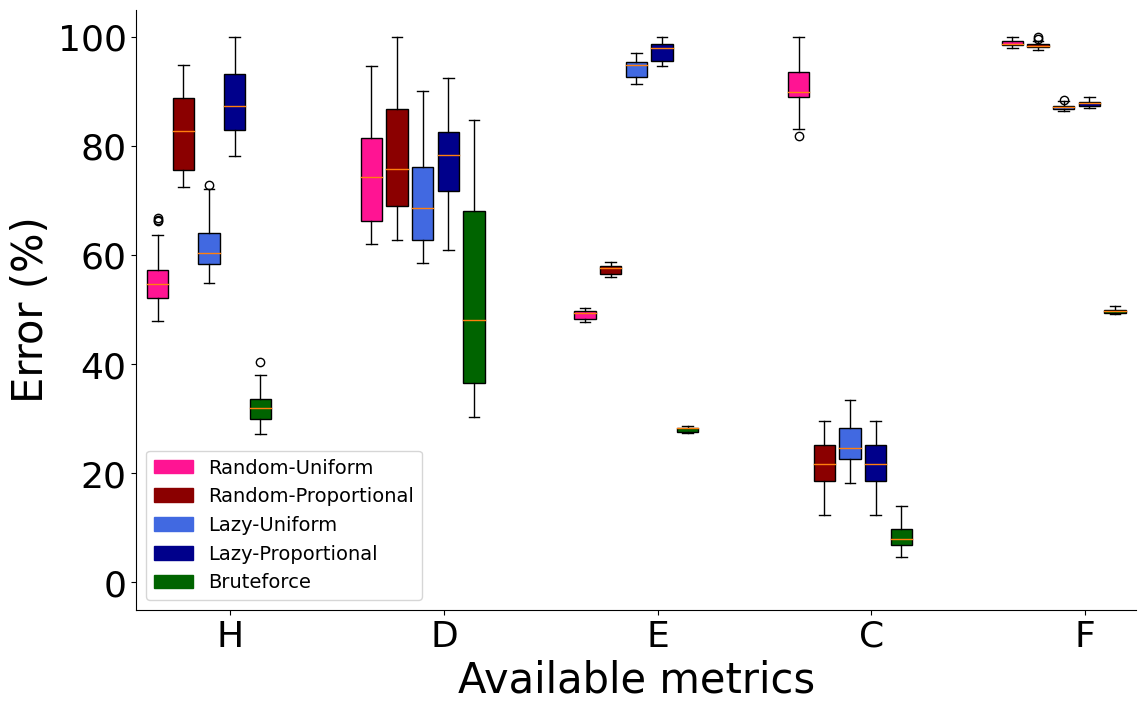

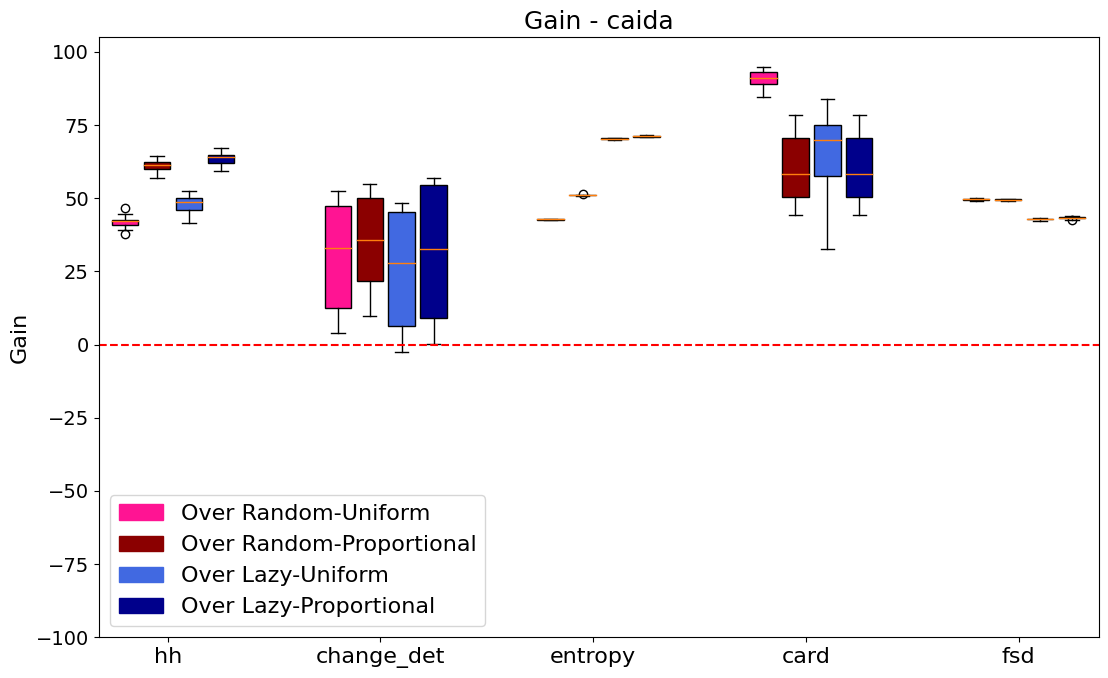

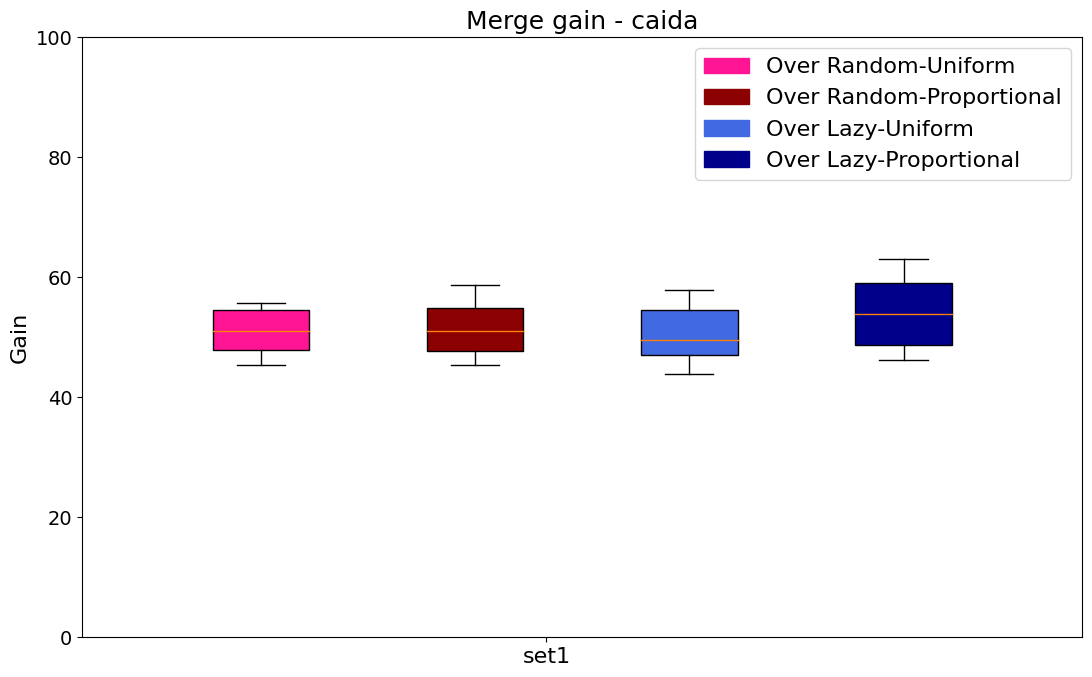

Num of run: 5
max_list: {'hh': 2365.1829787234046, 'change_det': 1753.8691489361695, 'entropy': 76.82697606015086, 'card': 4.026958757093719, 'fsd': 1.7750209658711065}


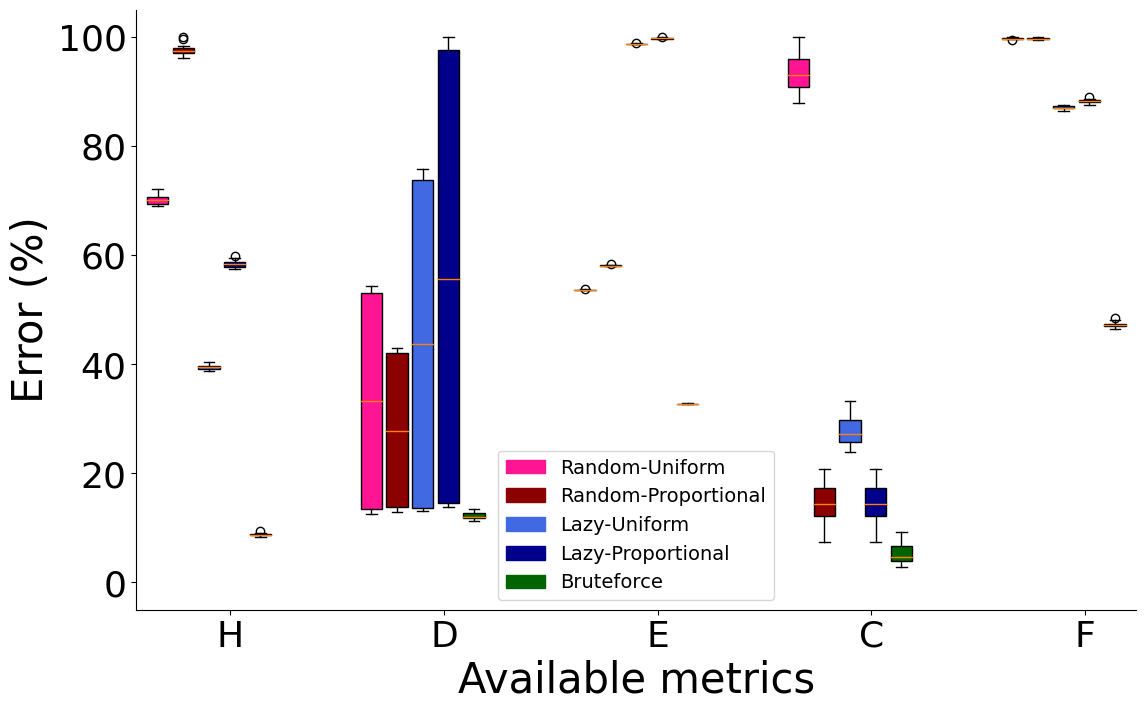

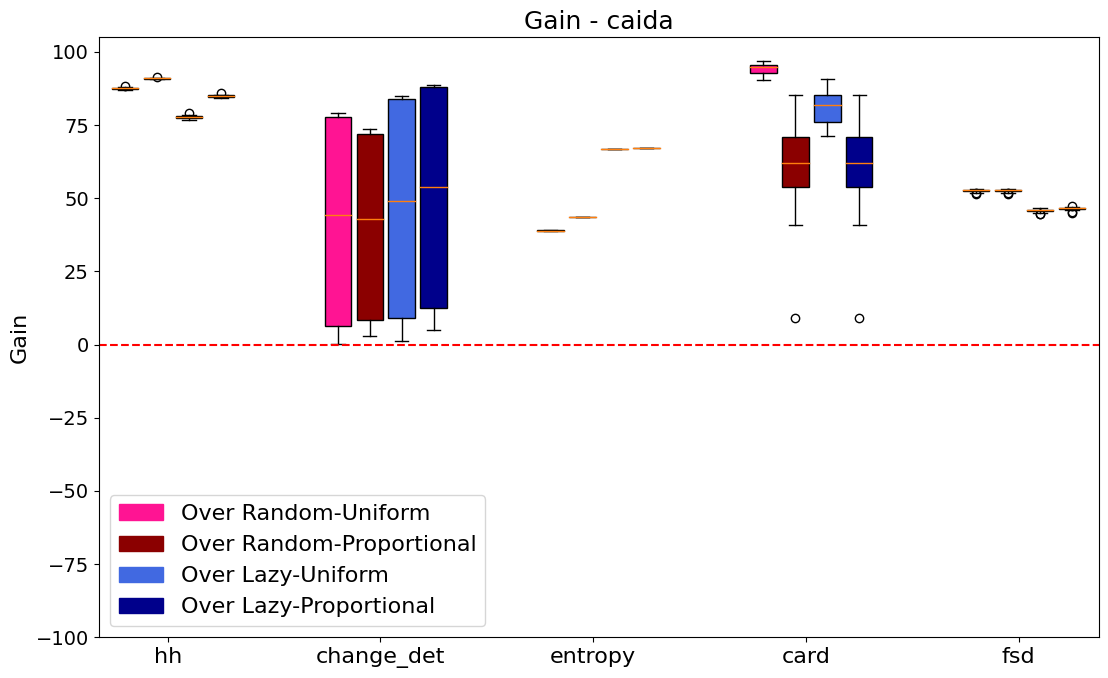

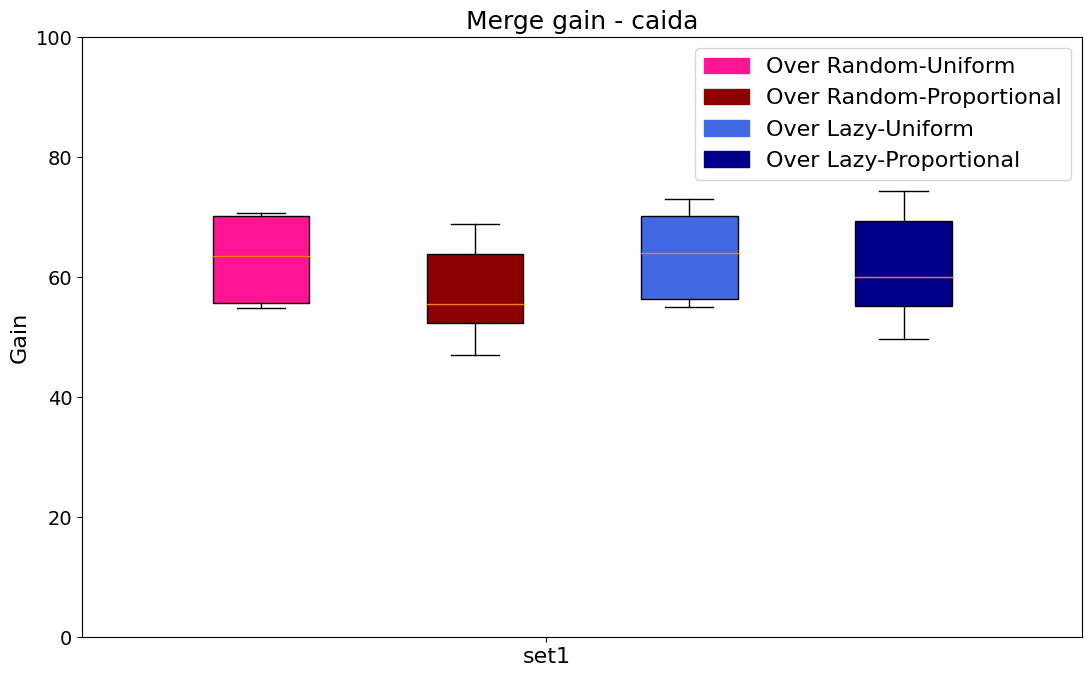

Num of run: 5
max_list: {'hh': 787.1918211946657, 'change_det': 592.4274345721876, 'entropy': 68.56800875231214, 'card': 4.026958757093719, 'fsd': 1.7647033673539425}


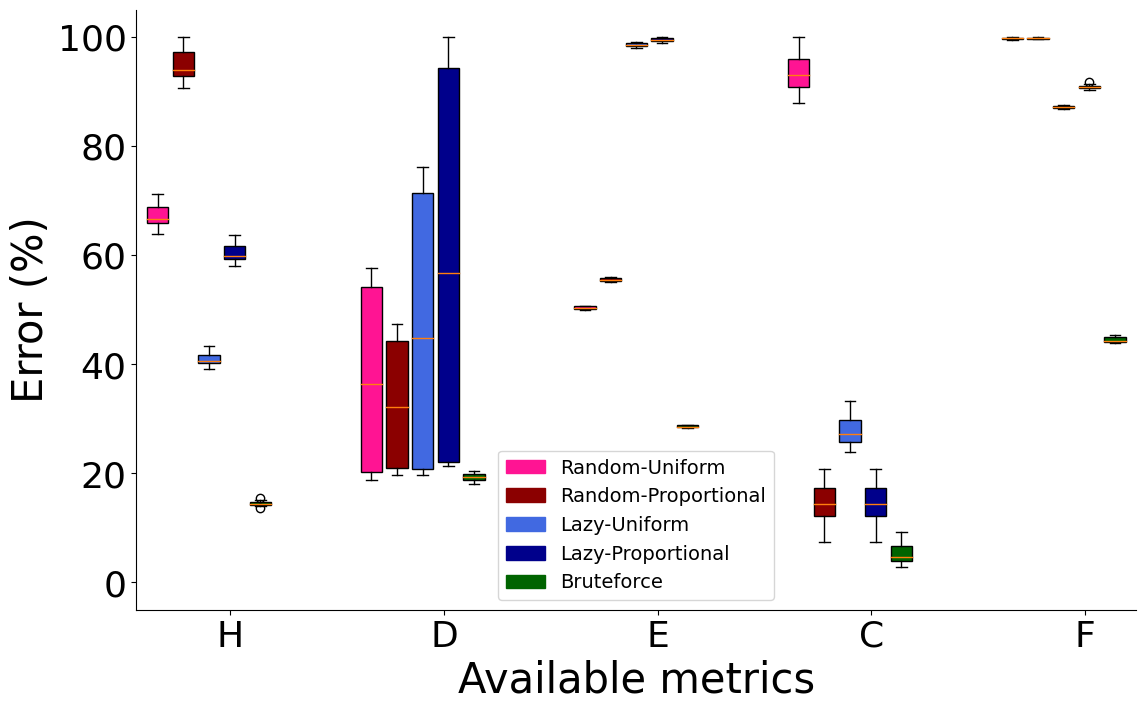

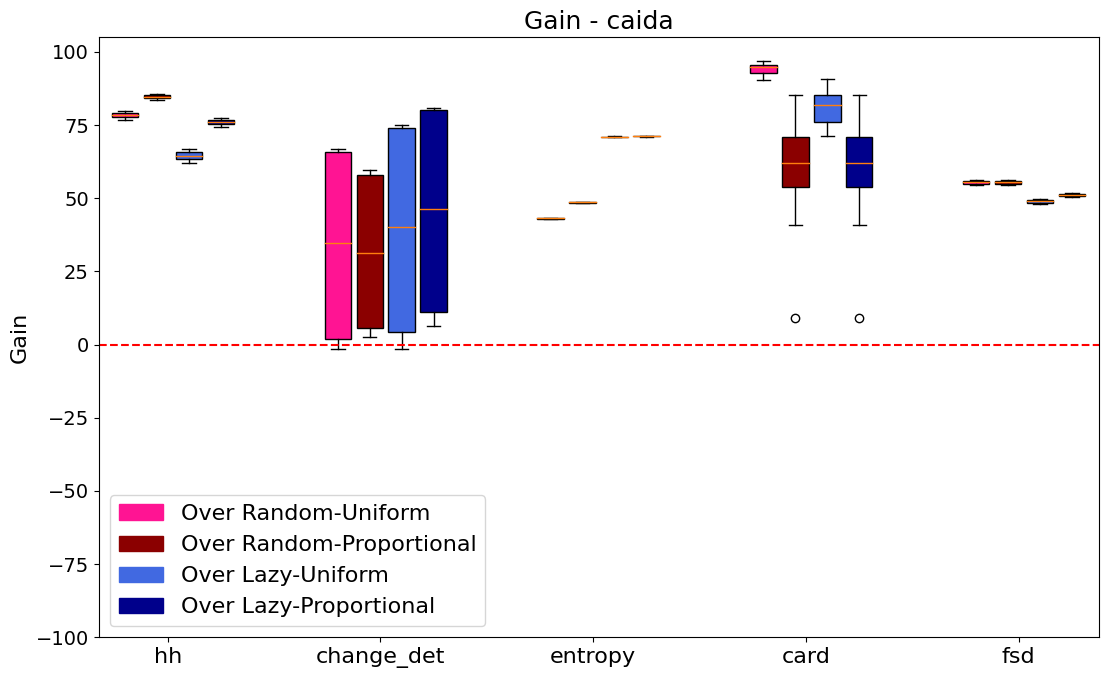

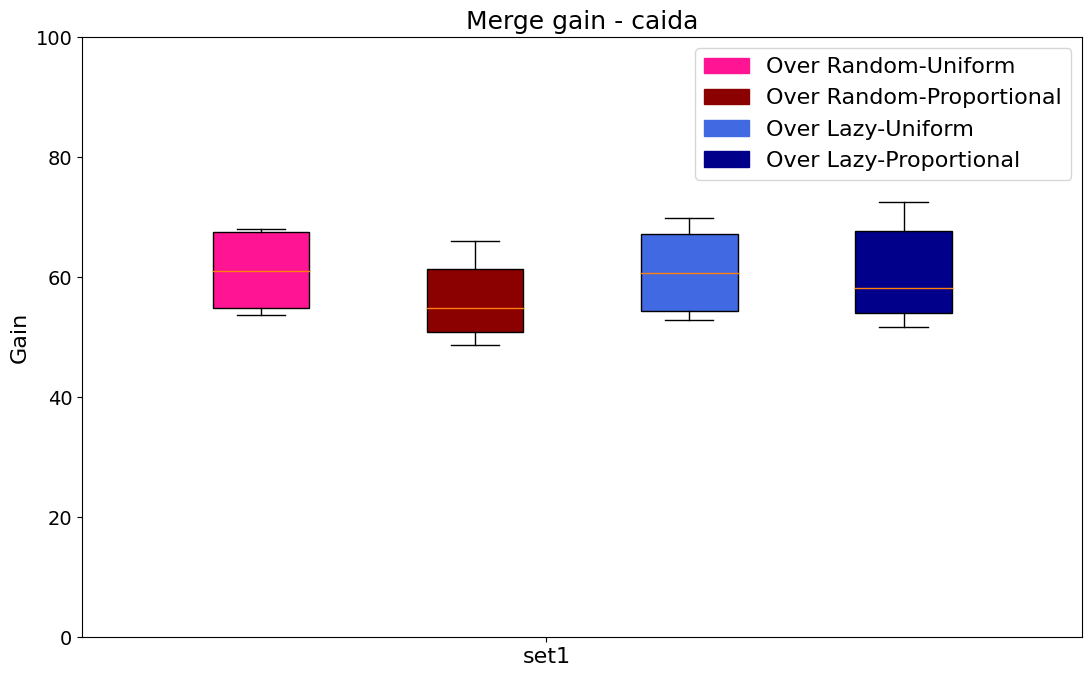

Num of run: 5
max_list: {'hh': 13.124794724397777, 'change_det': 12.773944032265595, 'entropy': 38.4450892022915, 'card': 2.882641164317032, 'fsd': 1.7670313331558685}


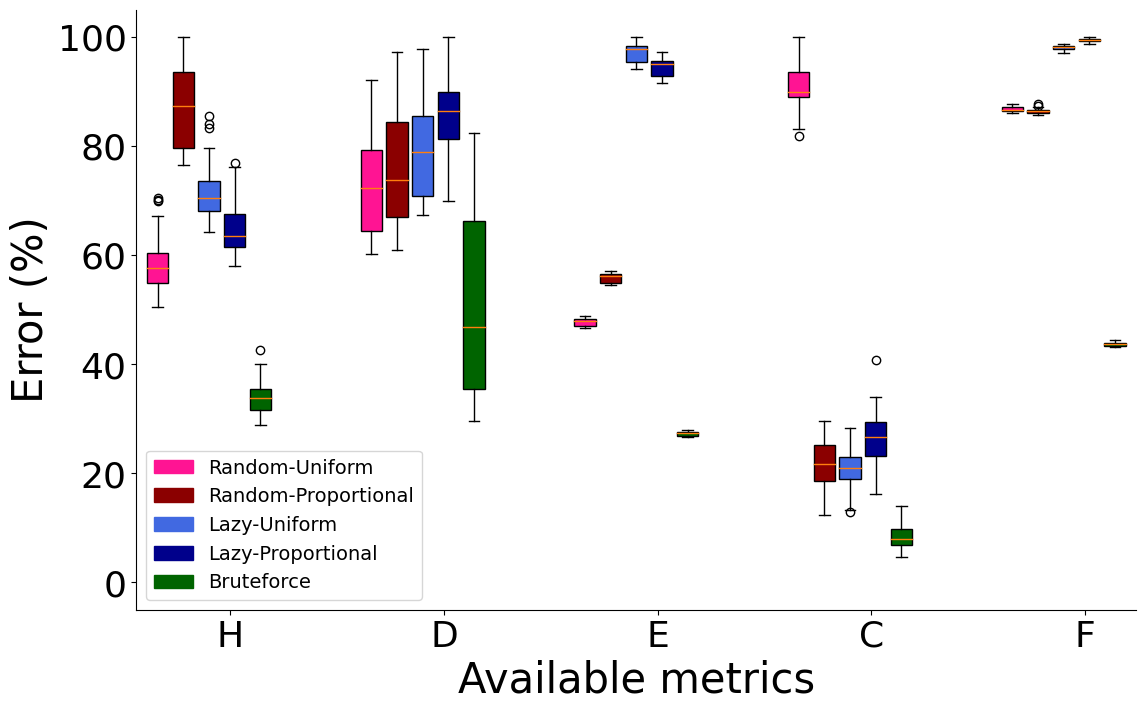

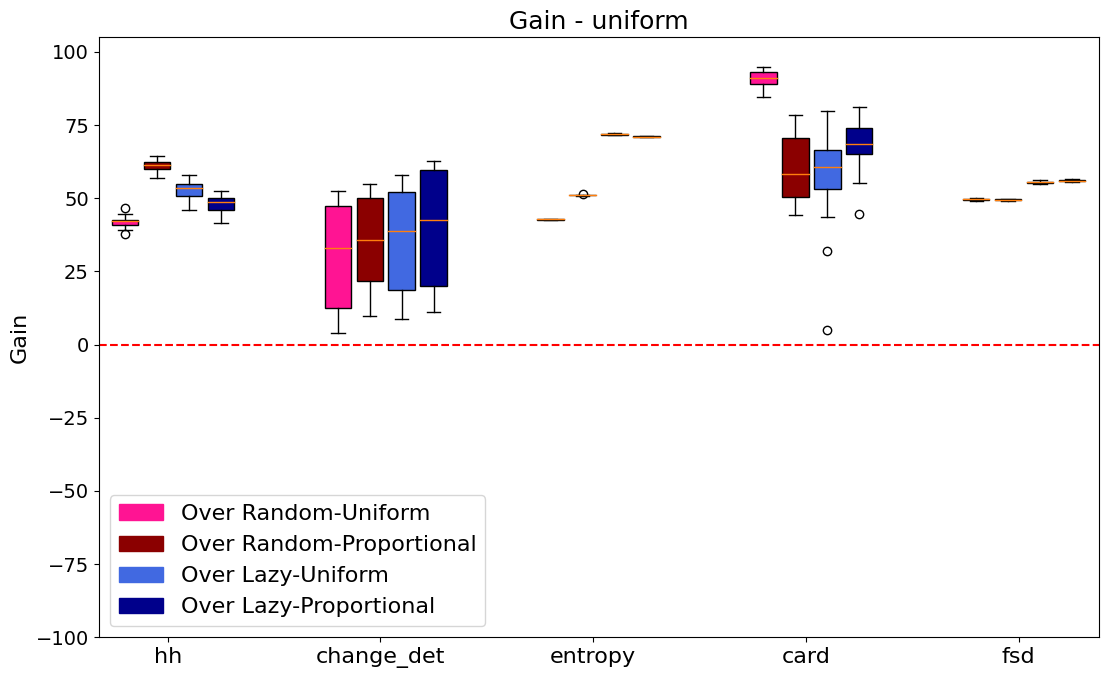

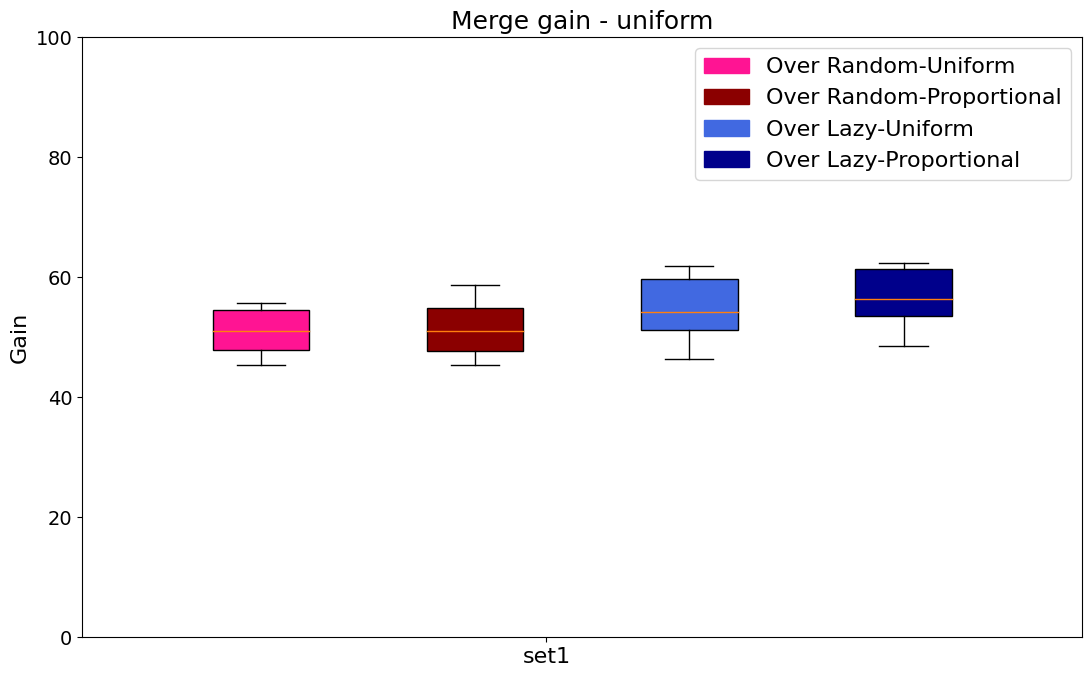

Num of run: 5
max_list: {'hh': 2365.1829787234046, 'change_det': 1389.7338297872338, 'entropy': 77.1568338495277, 'card': 4.026958757093719, 'fsd': 1.9995207985627146}


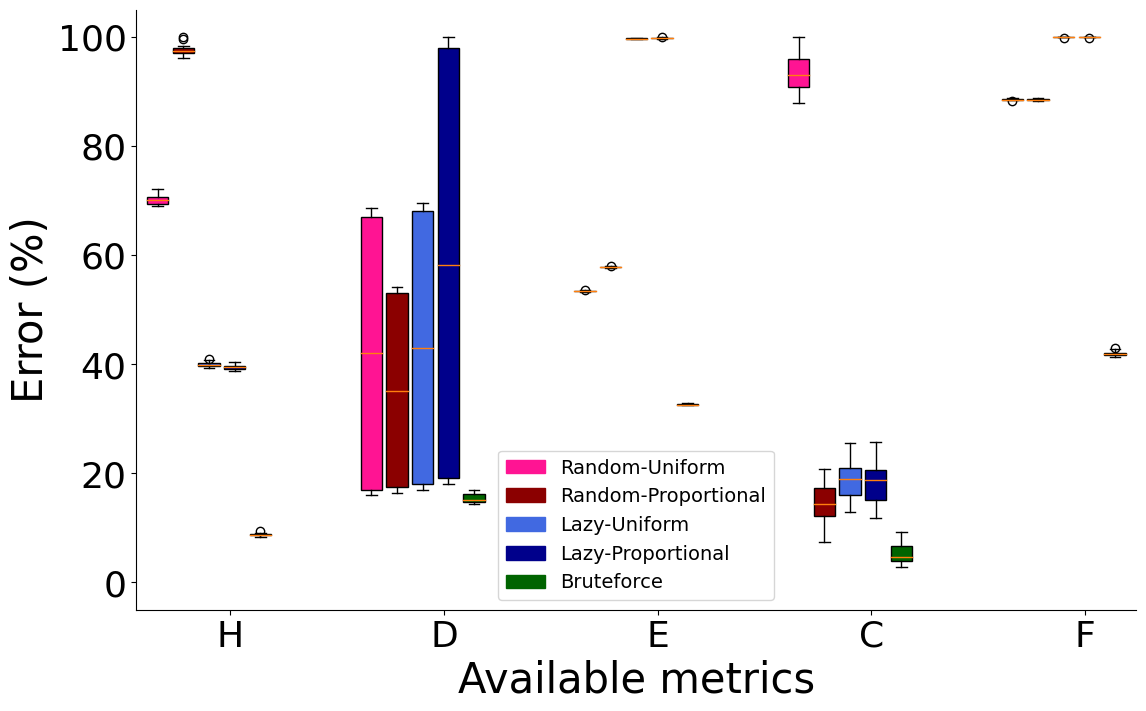

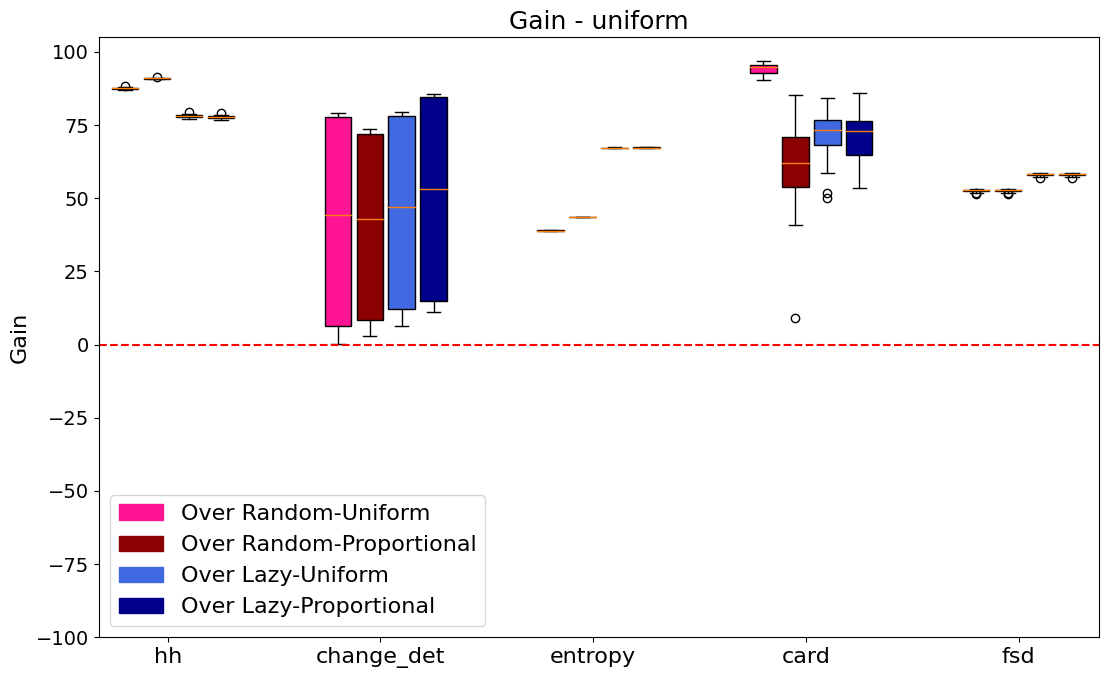

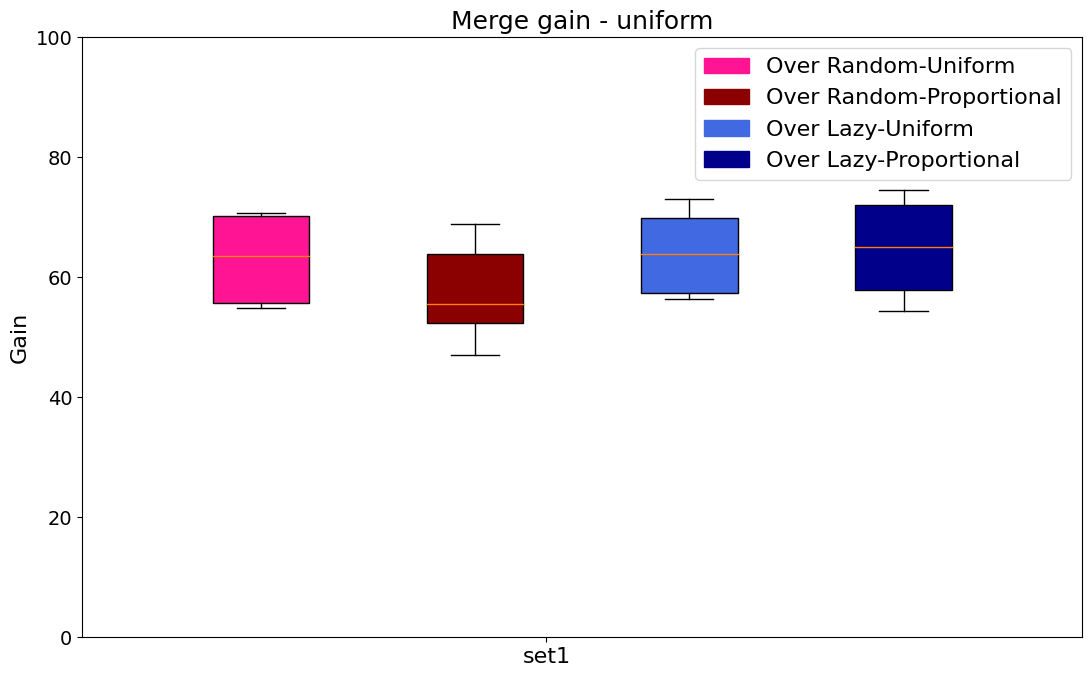

Num of run: 5
max_list: {'hh': 787.1918211946657, 'change_det': 490.1133663431443, 'entropy': 69.71101697639764, 'card': 4.026958757093719, 'fsd': 1.9977679709874363}


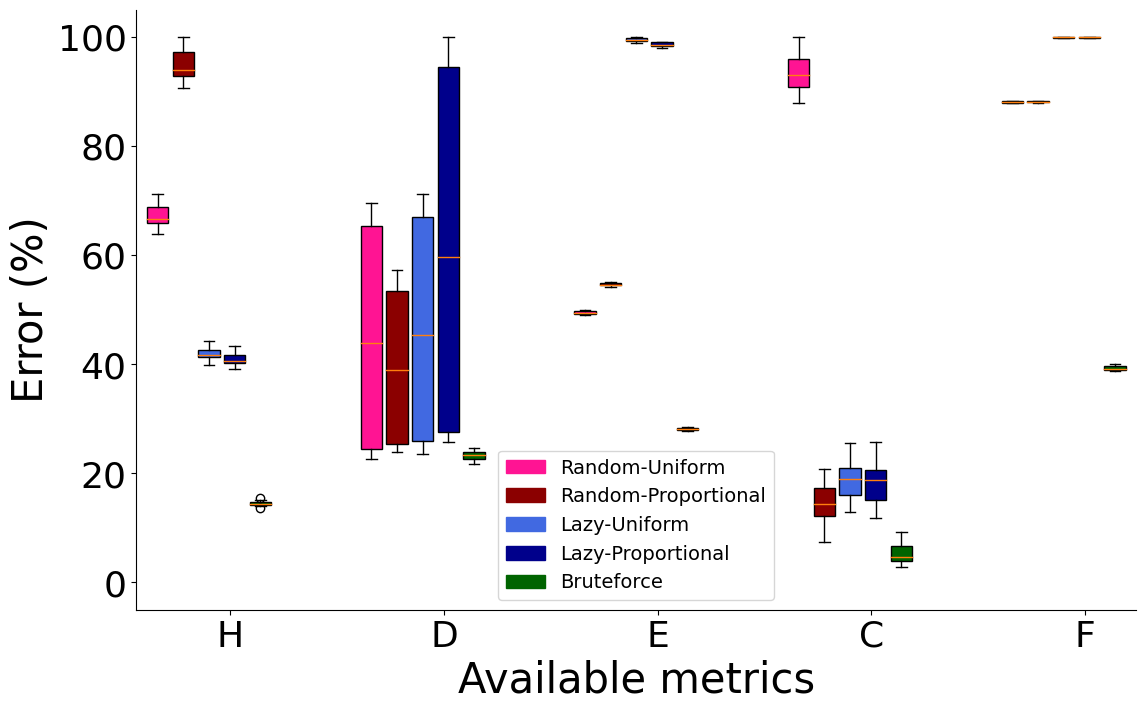

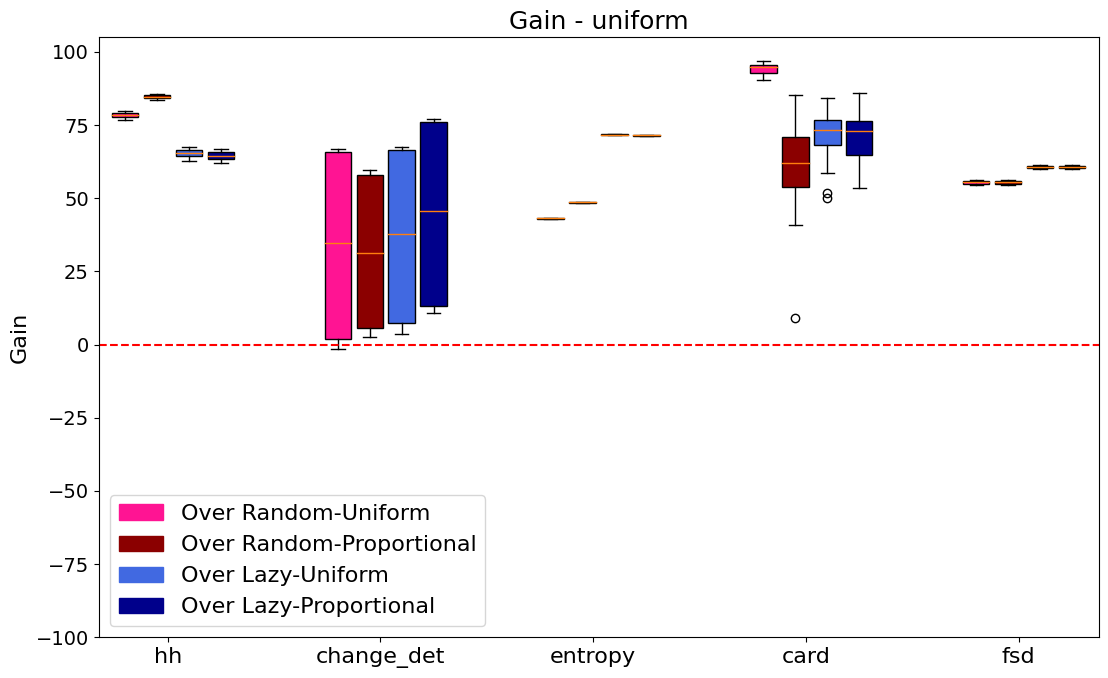

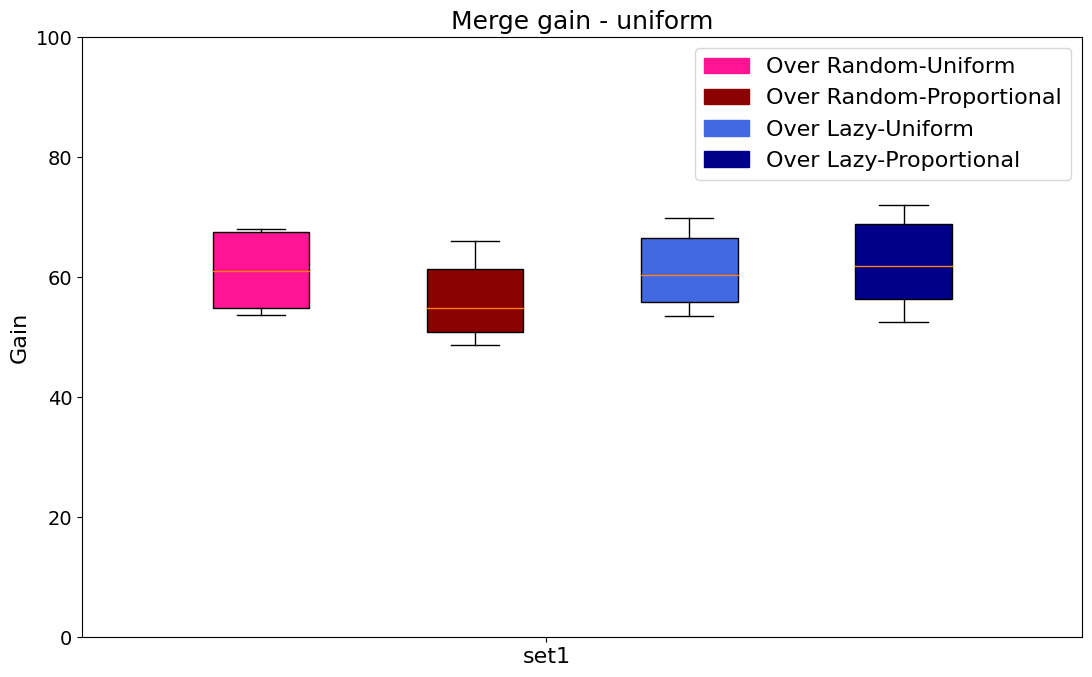

Num of run: 5
max_list: {'hh': 13.124794724397777, 'change_det': 12.419081864115473, 'entropy': 26.33588736365484, 'card': 10.488683380750233, 'fsd': 1.5717027205695207}


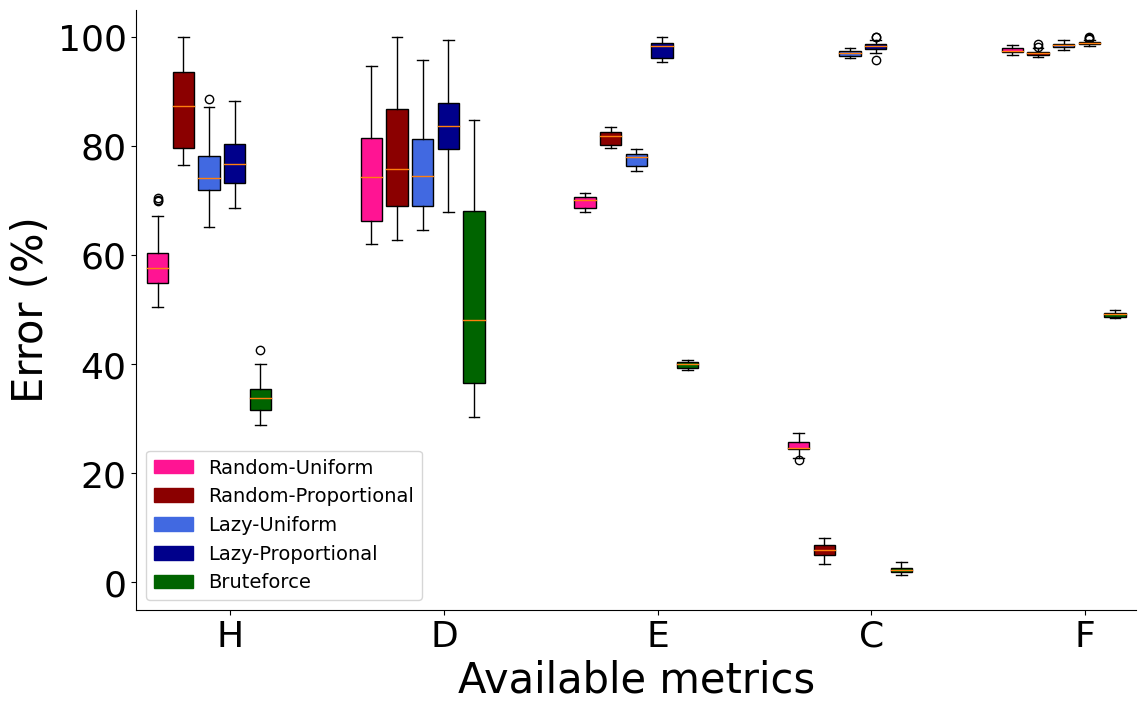

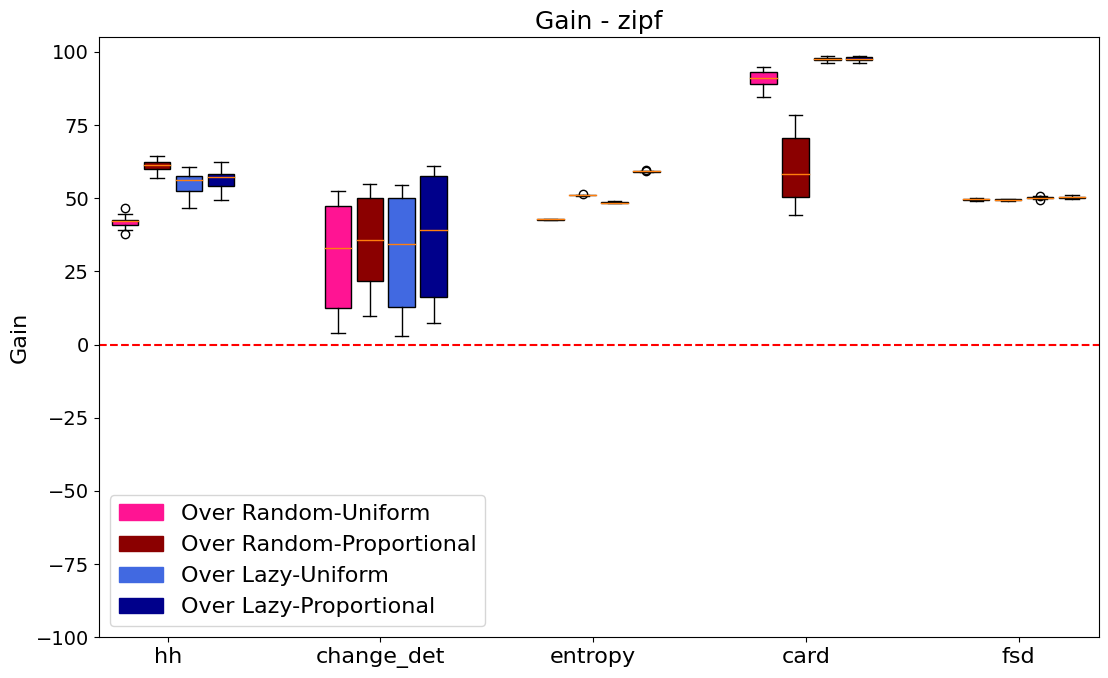

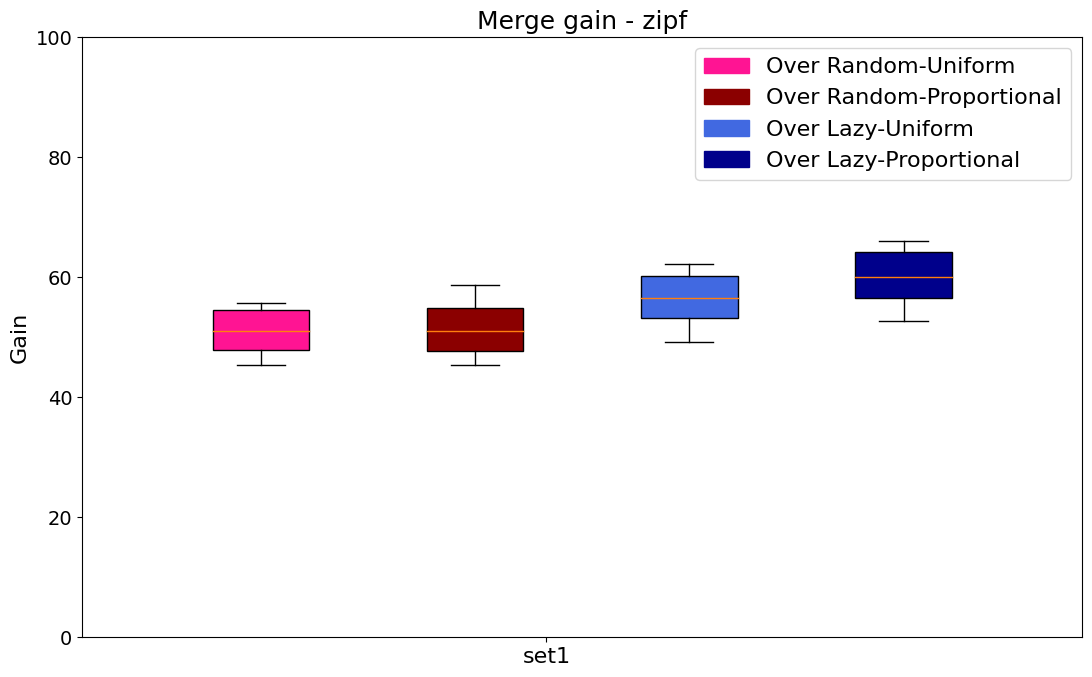

Num of run: 5
max_list: {'hh': 2365.1829787234046, 'change_det': 1557.3238297872338, 'entropy': 46.555064791474464, 'card': 10.463987237607551, 'fsd': 1.7764582511407272}


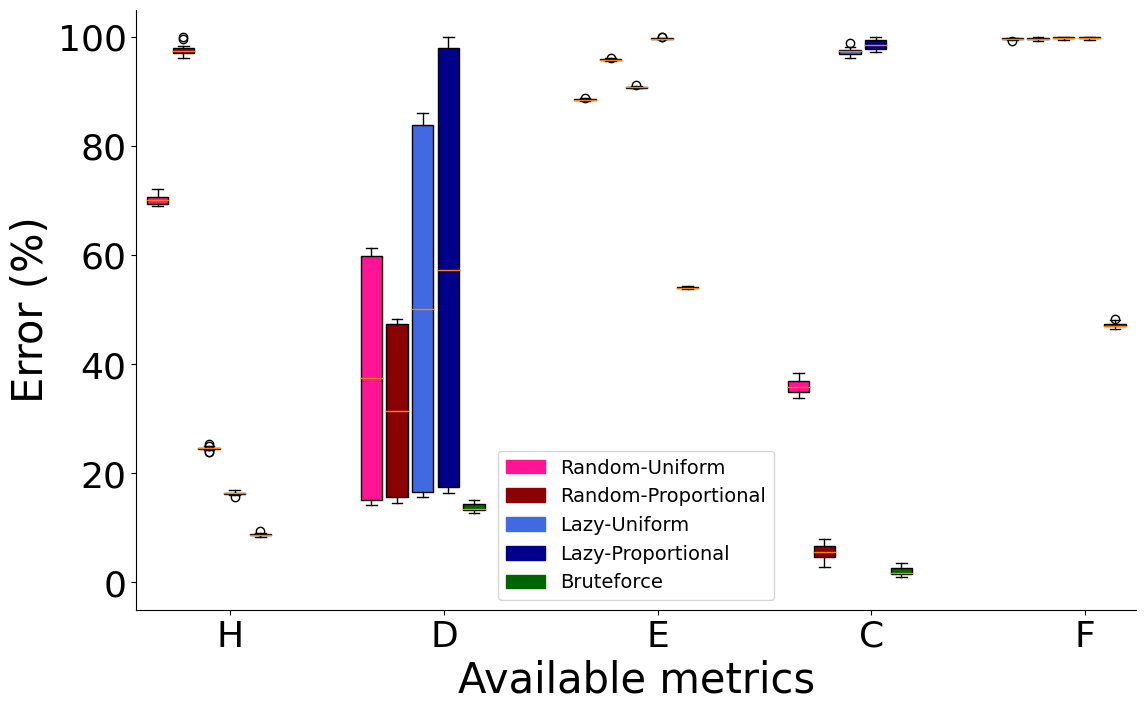

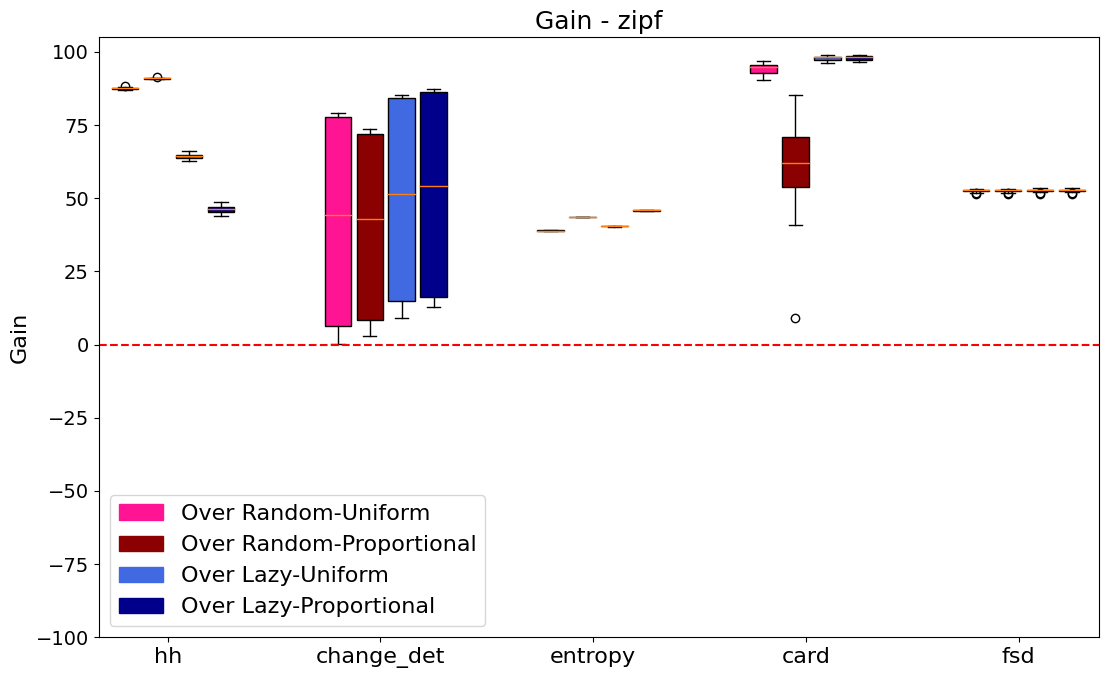

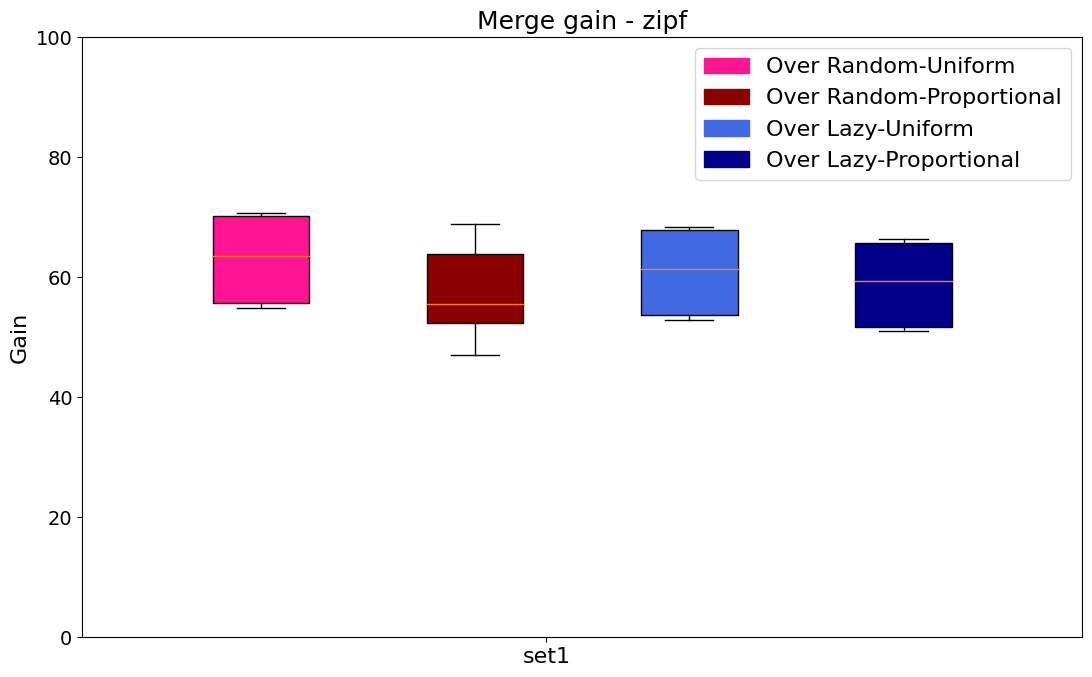

Num of run: 5
max_list: {'hh': 787.1918211946657, 'change_det': 536.0688747731398, 'entropy': 41.3562587717329, 'card': 10.463987237607551, 'fsd': 1.7728591755171401}


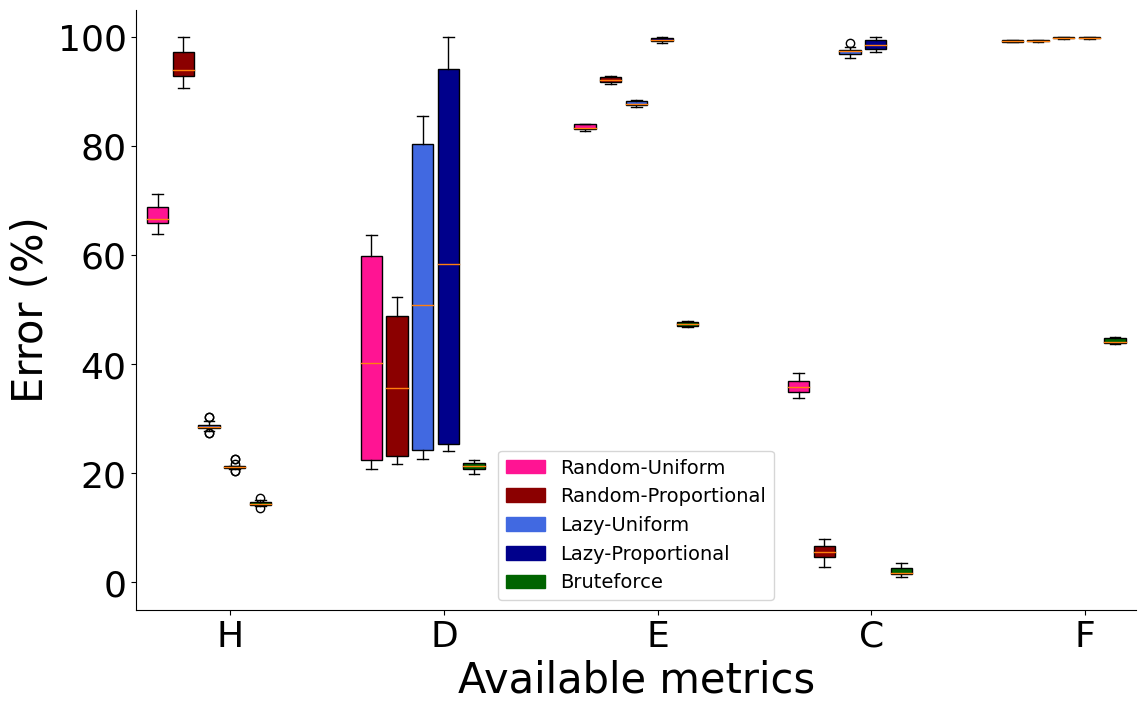

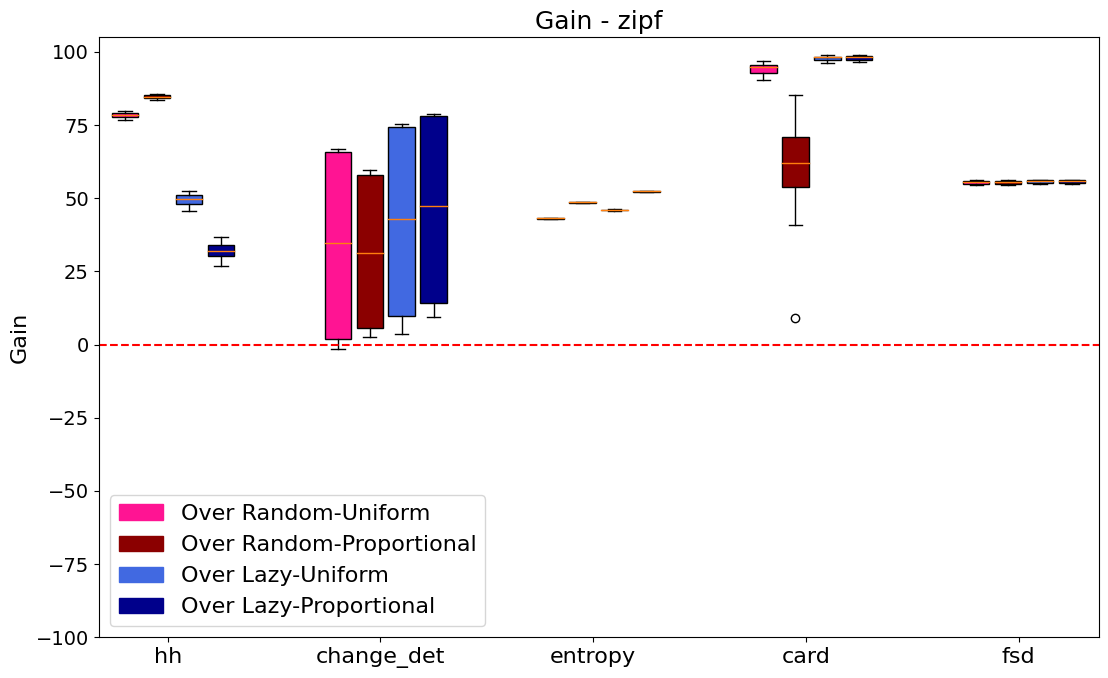

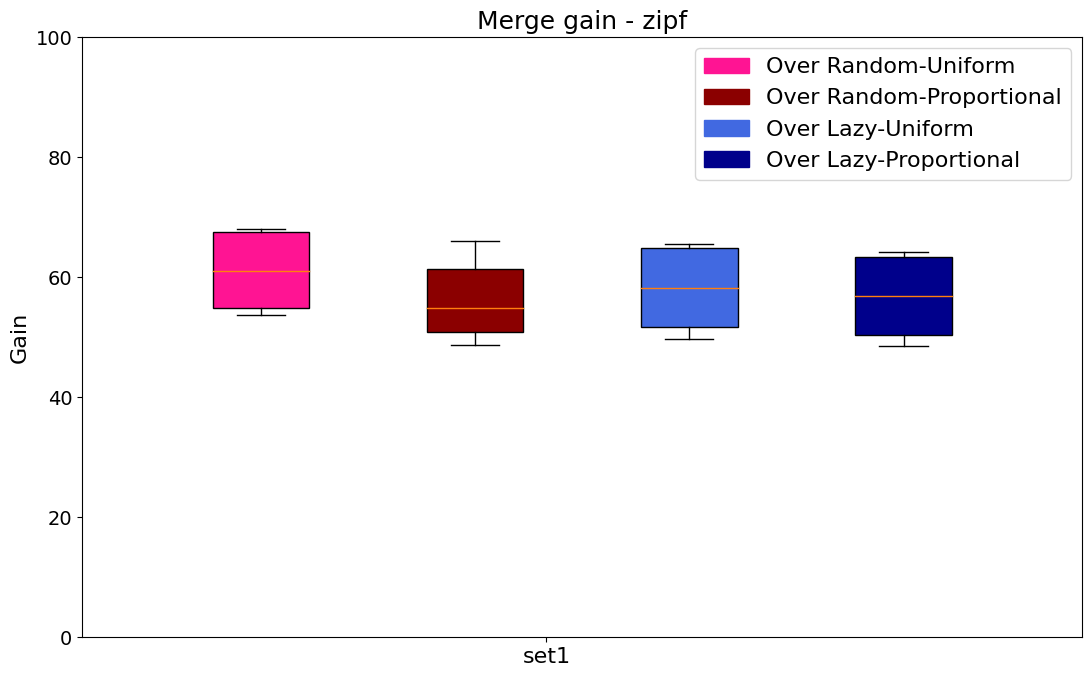

In [10]:
## testing datasets
datasets_list = [datasets_caida, datasets_uniform_fixFlowPkt, datasets_zipf_1point1_fixFlowPkt]

## run testing datasets
for datasets in datasets_list:
    ## run testing datasets on a trainingset
    loop_unit_caida(datasets)

for datasets in datasets_list:
    ## run testing datasets on a trainingset
    loop_unit_uniform(datasets)

for datasets in datasets_list:
    ## run testing datasets on a trainingset
    loop_unit_zipf(datasets)
    
# clear_output(wait=True)

In [11]:
print(f'len(global_merge_gain_all_mem): {len(global_merge_gain_all_mem)}')
num_of_strawmen = 4
num_of_datasets = len(datasets_list)

strawman_labels = ['over Random-Uniform', 'over Random-Proportional', 
                    'over Lazy-Uniform', 'over Lazy-Proportional']

len(global_merge_gain_all_mem): 36


In [12]:
ytick_labels = ["caida", "uniform", "zipf"]
xtick_labels = ["caida", "uniform", "zipf"]

title = "Error reduction"

[[51.15603458 62.98187561 61.02140933]
 [51.15603458 62.98187561 61.02140933]
 [51.15603458 62.98187561 61.02140933]]


/tmp/ipykernel_20676/2478466323.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  top = cm.get_cmap('Oranges_r', 128)
/tmp/ipykernel_20676/2478466323.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  bottom = cm.get_cmap('Blues', 128)


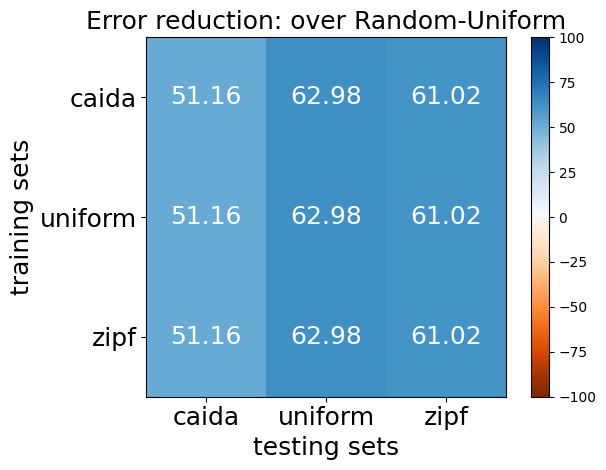

[[51.34285438 57.5995118  56.18974101]
 [51.34285438 57.5995118  56.18974101]
 [51.34285438 57.5995118  56.18974101]]


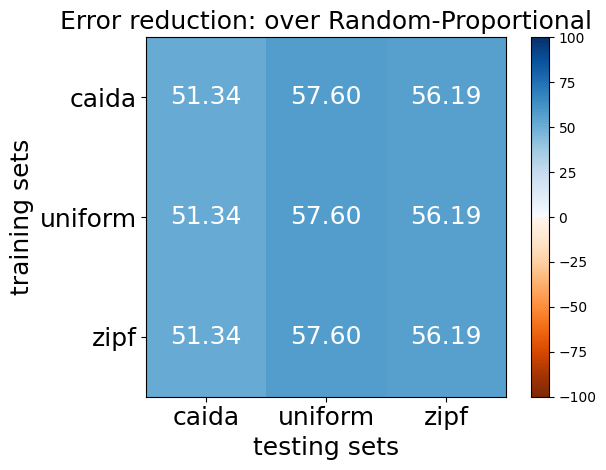

[[50.49513797 63.48855956 60.94082934]
 [54.70349867 63.8871165  61.17909148]
 [56.57492516 60.83982246 58.14922124]]


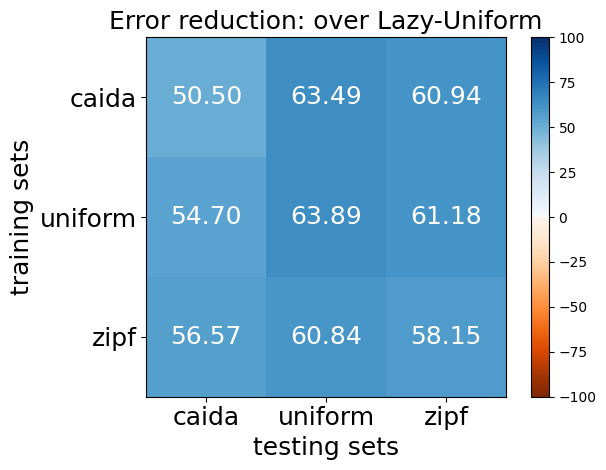

[[53.94223176 61.90976528 60.88542832]
 [56.57559596 64.80535792 62.44093885]
 [60.0186622  58.86098891 56.74376261]]


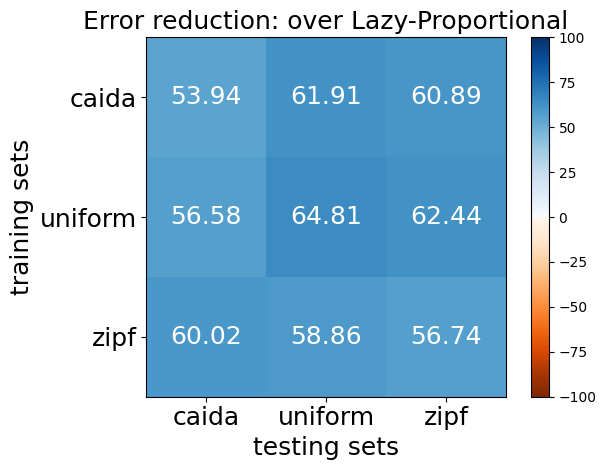

In [13]:
for offset_strawman in range(num_of_strawmen):
    error_reductions = []
    ll = []
    ## iterate over 3x3
    for i in range(num_of_datasets**2):
        idx = i * num_of_strawmen + offset_strawman
        
        # print(idx)
        ll.append(np.mean(global_merge_gain_all_mem[idx]))
        if len(ll) == num_of_datasets:
            error_reductions.append(ll)
            ll = []
    error_reductions = np.array(error_reductions)
    
    title = f"Error reduction: {strawman_labels[offset_strawman]}"
    print(error_reductions)
    
    plot_heatmap(error_reductions, ytick_labels, xtick_labels, title)